<a href="https://colab.research.google.com/github/sancarg/Machine_Learning/blob/master/Feature_Engineering_Beijing_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature_Engineering

# Introduction

In this notebook series, we’ll explore how different forecasting models can be applied to the same dataset and compare their strengths and weaknesses. To keep things consistent, both notebooks use the Beijing Multi-Site Air-Quality Data Set, which includes hourly air pollutant data collected from 12 monitoring sites between March 1st, 2013 and February 28th, 2017. We’ll focus on three models—SARIMAX, LightGBM, and DeepAR—to predict air pollution levels and see how their results differ when applied to the same real-world case.

**The Beijing Multi-Site Air Quality** dataset (often found on platforms like Kaggle or UCI Machine Learning Repository) typically includes hourly data for:

**Air Pollutants:** PM2.5, PM10, SO2, NO2, CO, O3.

**Meteorological Variables:** Temperature (TEMP), Pressure (PRES), Dew Point (DEWP), Rainfall (RAIN), Wind Speed (WSPM), Wind Direction (WDIR).

- **PM2.5 (Particulate Matter 2.5 micrometers or less in diameter):** These are fine inhalable particles with a diameter of 2.5 micrometers or less. They are often produced from combustion processes (like vehicle exhaust and power plants) and can also be formed in the atmosphere. Due to their small size, they can travel deep into the lungs and even enter the bloodstream, causing significant health issues.

- **PM10 (Particulate Matter 10 micrometers or less in diameter):** These are inhalable particles with a diameter of 10 micrometers or less. They include dust, pollen, and mold spores. These particles can get into the lungs and cause health problems.

- **SO2 (Sulfur Dioxide):** Sulfur dioxide is a gas produced by burning fossil fuels that contain sulfur, such as coal and oil. It is a major contributor to acid rain and can cause respiratory problems.

- **NO2 (Nitrogen Dioxide):** Nitrogen dioxide is a gas that is primarily produced from the burning of fossil fuels (like in vehicles and power plants). It contributes to the formation of smog and acid rain and can cause respiratory issues.

- **CO (Carbon Monoxide):** Carbon monoxide is a colorless, odorless gas produced by incomplete combustion of carbon-containing fuels (such as gasoline, coal, wood, and natural gas). It is particularly dangerous because it binds to hemoglobin in the blood more effectively than oxygen, reducing the blood’s ability to carry oxygen to vital organs and tissues.

- **O3 (Ozone):** Ozone is a gas that occurs naturally in the upper atmosphere, where it protects us from the sun's ultraviolet rays. However, at ground level, it is a harmful air pollutant that can cause respiratory problems.

- **TEMP** isTemperature

- **PRES** almost certainly stands for Atmospheric Pressure (also known as Barometric Pressure).

- **DEWP** refers to Dew Point. Dew point is the temperature at which air must be cooled to become saturated with water vapor. While it's a meteorological variable often included in air quality datasets as it influences atmospheric conditions and pollutant dispersion.

- **wd (Wind Direction)** The values in this column would typically be categorical ('E', 'ENE', 'NNE', 'N', 'NNW', 'NW', 'NE', 'SW', 'SSW', 'WSW',
'ESE', 'SE', 'S', 'WNW', 'SSE', 'W')

- **WSPM** refers to Wind Speed (in meters per second, or some other unit).

# Preparation

In [1]:
import os
import pandas as pd
import numpy as np
import json
import zipfile
import io
import requests
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'beijing-multisite-airquality-data-set' dataset.
Path to dataset files: /kaggle/input/beijing-multisite-airquality-data-set


In [4]:
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f)

Found 12 CSV files:
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Guanyuan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanliu_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Tiantan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanshouxigong_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Nongzhanguan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Shunyi_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Changping_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Dingling_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Huairou_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality

In [5]:
dataset = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        # It's common for these files to have a 'station' column, or we can extract it from the filename
        # Let's extract station name from the filename for consistency if it's not already there.
        # Example filename: PRSA_Data_Aotizhongxin_20130301-20170228.csv
        station_name = os.path.basename(file).split('_')[2]
        df['station'] = station_name

        # Create 'datetime' column
        #df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

        # Drop original date components and 'No' column
        #df = df.drop(columns=['year', 'month', 'day', 'hour', 'No']) # 'No' is usually just a row number
        # --- FIX: Reorder the columns to put 'datetime' first ---
        # Get a list of all columns
        cols = list(df.columns)

        # Remove 'datetime' from its current position
        #cols.remove('datetime')

        # Insert 'datetime' at the beginning of the list
        #cols.insert(0, 'datetime')

        # Re-index the DataFrame with the new column order
        #df = df[cols]

        dataset.append(df)
        print(f"Successfully loaded {file} with {len(df)} rows. Added station: {station_name}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Guanyuan_20130301-20170228.csv with 35064 rows. Added station: Guanyuan
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv with 35064 rows. Added station: Aotizhongxin
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanliu_20130301-20170228.csv with 35064 rows. Added station: Wanliu
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Tiantan_20130301-20170228.csv with 35064 rows. Added station: Tiantan
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanshouxigong_20130301-20170228.csv with 35064 rows. Added station: Wanshouxigong
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Nongzhanguan_20130301-20170228.csv with 35064 rows. Added station: Nongzhanguan
Successfully loaded /kaggle/input/beijing-multisite-airq

In [6]:
df = pd.concat(dataset, ignore_index=False)

display(df.head())
display(df.tail())

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  14.0  20.0  300.0  69.0  -0.7   
1   2  2013      3    1     1    4.0   4.0  13.0  17.0  300.0  72.0  -1.1   
2   3  2013      3    1     2    3.0   3.0  10.0  19.0  300.0  69.0  -1.1   
3   4  2013      3    1     3    3.0   6.0   7.0  24.0  400.0  62.0  -1.4   
4   5  2013      3    1     4    3.0   6.0   5.0  14.0  400.0  71.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1023.0 -18.8   0.0  NNW   4.4  Guanyuan  
1  1023.2 -18.2   0.0    N   4.7  Guanyuan  
2  1023.5 -18.2   0.0  NNW   5.6  Guanyuan  
3  1024.5 -19.4   0.0   NW   3.1  Guanyuan  
4  1025.2 -19.5   0.0    N   2.0  Guanyuan

No  year  month  day  hour  PM2.5  PM10   SO2   NO2      CO    O3  \
35059  35060  2017      2   28    19   16.0  51.0   3.0  29.0   400.0  73.0   
35060  35061  2017      2   28    20   18.0  45.0   3.0  43.0   500.0  54.0   
35061  35062  2017      2   28    21   23.0  58.0   5.0  61.0   700.0  28.0   
35062  35063  2017      2   28    22   23.0  53.0   9.0  75.0   900.0  15.0   
35063  35064  2017      2   28    23   30.0  71.0  11.0  87.0  1200.0   4.0   

       TEMP    PRES  DEWP  RAIN   wd  WSPM station  
35059  12.5  1013.5 -16.2   0.0   NW   2.4  Dongsi  
35060  11.6  1013.6 -15.1   0.0  WNW   0.9  Dongsi  
35061  10.8  1014.2 -13.3   0.0   NW   1.1  Dongsi  
35062  10.5  1014.4 -12.9   0.0  NNW   1.2  Dongsi  
35063   8.6  1014.1 -15.9   0.0  NNE   1.3  Dongsi

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 61.0+ MB


Wind Direction is a categorical column and needs to be handled differently than numerical data. The best approach is a two-step process:

**Handle Missing Values:** Since interpolation doesn't apply to categories, a good method is to fill the missing values with the most frequent wind direction (the mode).

**Encode the Column:** Machine learning models require numerical input. The best method for wind direction is One-Hot Encoding, which creates a new binary column for each unique direction. This avoids introducing a false sense of order that Label Encoding would (e.g., 'N' is not 'less than' 'SSW').

In [8]:
wd_mode = df['wd'].mode()[0]

# Fill the missing 'wd' values with the mode
df['wd'] = df['wd'].fillna(wd_mode)
#df.fillna({col: wd}, inplace=True)
print(f"Missing values in 'wd' filled with the mode: {wd_mode}")

Missing values in 'wd' filled with the mode: NE


In [9]:
df['wd_degrees'] = df['wd'].map({
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5, 'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5, 'S': 180, 'SSW': 202.5,
    'SW': 225, 'WSW': 247.5, 'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5})

In [10]:
# Step 2: One-Hot Encode the 'wd' column ---
# This creates new binary columns for each unique wind direction.
df = pd.get_dummies(df, columns=['wd'], prefix='wd', dtype=int)

In [11]:
df

No  year  month  day  hour  PM2.5  PM10   SO2   NO2      CO    O3  \
0          1  2013      3    1     0    4.0   4.0  14.0  20.0   300.0  69.0   
1          2  2013      3    1     1    4.0   4.0  13.0  17.0   300.0  72.0   
2          3  2013      3    1     2    3.0   3.0  10.0  19.0   300.0  69.0   
3          4  2013      3    1     3    3.0   6.0   7.0  24.0   400.0  62.0   
4          5  2013      3    1     4    3.0   6.0   5.0  14.0   400.0  71.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...     ...   ...   
35059  35060  2017      2   28    19   16.0  51.0   3.0  29.0   400.0  73.0   
35060  35061  2017      2   28    20   18.0  45.0   3.0  43.0   500.0  54.0   
35061  35062  2017      2   28    21   23.0  58.0   5.0  61.0   700.0  28.0   
35062  35063  2017      2   28    22   23.0  53.0   9.0  75.0   900.0  15.0   
35063  35064  2017      2   28    23   30.0  71.0  11.0  87.0  1200.0   4.0   

       TEMP    PRES  DEWP  RAIN  WSPM   station  wd_degrees  wd_E  wd_ENE  \
0      -0.7  1023.0 -18.8   0.0   4.4  Guanyuan       337.5     0       0   
1      -1.1  1023.2 -18.2   0.0   4.7  Guanyuan         0.0     0       0   
2      -1.1  1023.5 -18.2   0.0   5.6  Guanyuan       337.5     0       0   
3      -1.4  1024.5 -19.4   0.0   3.1  Guanyuan       315.0     0       0   
4      -2.0  1025.2 -19.5   0.0   2.0  Guanyuan         0.0     0       0   
...     ...     ...   ...   ...   ...       ...         ...   ...     ...   
35059  12.5  1013.5 -16.2   0.0   2.4    Dongsi       315.0     0       0   
35060  11.6  1013.6 -15.1   0.0   0.9    Dongsi       292.5     0       0   
35061  10.8  1014.2 -13.3   0.0   1.1    Dongsi       315.0     0       0   
35062  10.5  1014.4 -12.9   0.0   1.2    Dongsi       337.5     0       0   
35063   8.6  1014.1 -15.9   0.0   1.3    Dongsi        22.5     0       0   

       wd_ESE  wd_N  wd_NE  wd_NNE  wd_NNW  wd_NW  wd_S  wd_SE  wd_SSE  \
0           0     0      0       0       1      0     0      0       0   
1           0     1      0       0       0      0     0      0       0   
2           0     0      0       0       1      0     0      0       0   
3           0     0      0       0       0      1     0      0       0   
4           0     1      0       0       0      0     0      0       0   
...       ...   ...    ...     ...     ...    ...   ...    ...     ...   
35059       0     0      0       0       0      1     0      0       0   
35060       0     0      0       0       0      0     0      0       0   
35061       0     0      0       0       0      1     0      0       0   
35062       0     0      0       0       1      0     0      0       0   
35063       0     0      0       1       0      0     0      0       0   

       wd_SSW  wd_SW  wd_W  wd_WNW  wd_WSW  
0           0      0     0       0       0  
1           0      0     0       0       0  
2           0      0     0       0       0  
3           0      0     0       0       0  
4           0      0     0       0       0  
...       ...    ...   ...     ...     ...  
35059       0      0     0       0       0  
35060       0      0     0       1       0  
35061       0      0     0       0       0  
35062       0      0     0       0       0  
35063       0      0     0       0       0  

[420768 rows x 34 columns]

To figure out the length of the missing gaps for our data, we can use a clever trick with pandas' isnull() and cumsum() functions. **This will allow you to count how many consecutive NaN values** there are in each column.

This function will take a single column of your data and return a list of the lengths of all the consecutive missing value blocks.

In [12]:
def get_missing_gap_lengths(series):

    # Create a boolean Series where True indicates a missing value
    is_null = series.isnull()

    # Use cumsum() to create a unique ID for each block of consecutive NaNs.
    # The cumsum resets every time a non-null value is encountered.
    group_id = (~is_null).cumsum()

    # Group the missing values by their ID and count them
    missing_gaps = is_null.groupby(group_id).sum()

    # Filter out the non-NaN groups (where the sum is 0)
    return missing_gaps[missing_gaps > 0]

In [13]:
# List of columns to analyze for missing gaps
columns_to_check = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for column in columns_to_check:
    # Use get_missing_gap_lengths function on each station's data
    gap_lengths = df.groupby('station')[column].apply(get_missing_gap_lengths)

    # Print a summary of the gap lengths
    print(f"--- Summary of missing value gaps for column: {column} ---")
    if not gap_lengths.empty:
        # Flatten the MultiIndex to get a single Series of all gap lengths
        all_lengths = gap_lengths.reset_index(drop=True)
        print(all_lengths.describe())

        # Count how many gaps are 1-3 hours long
        short_gaps = all_lengths[(all_lengths >= 1) & (all_lengths <= 3)].count()
        total_gaps = all_lengths.count()
        if total_gaps > 0:
            short_gap_percentage = (short_gaps / total_gaps) * 100
            print(f"Percentage of gaps that are 1-3 hours long: {short_gap_percentage:.2f}%")
    else:
        print("No missing values found.")
    print("\n")

--- Summary of missing value gaps for column: TEMP ---
count    234.000000
mean       1.700855
std        1.606131
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: TEMP, dtype: float64
Percentage of gaps that are 1-3 hours long: 88.46%


--- Summary of missing value gaps for column: PRES ---
count    235.000000
mean       1.672340
std        1.574055
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: PRES, dtype: float64
Percentage of gaps that are 1-3 hours long: 89.36%


--- Summary of missing value gaps for column: DEWP ---
count    237.000000
mean       1.700422
std        1.599430
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        7.000000
Name: DEWP, dtype: float64
Percentage of gaps that are 1-3 hours long: 88.61%


--- Summary of missing value gaps for column: RAIN ---
count    238.000000
mean       1.638655
std        1.527421


The data consistently shows that the overwhelming majority of your missing values are very short.

- The median gap length is 1 hour for all columns.

- The mean gap length is consistently between 1.6 and 1.7 hours.

- Approximately 88-89% of all missing gaps are 1 to 3 hours long.

- The maximum gap length is very low, ranging from 5 to 7 hours.

Given these findings, a robust and simple approach for these columns would be to use **ffill or bfill** which are an excellent choice for categorical data or when you can assume the value remains constant for short periods. For our data, since over 88% of our missing gaps are 1-3 hours long, **ffill() or bfill()** would be a perfectly reasonable and quick solution.


For preserving temporal patterns **Spline or Linear Interpolation** has the biggest advantage that fills missing values by looking at the data points immediately before and after the gap. This means the imputed value respects the natural flow, trends, and cycles of the time series (e.g., the daily rise and fall of **O3 and CO**).

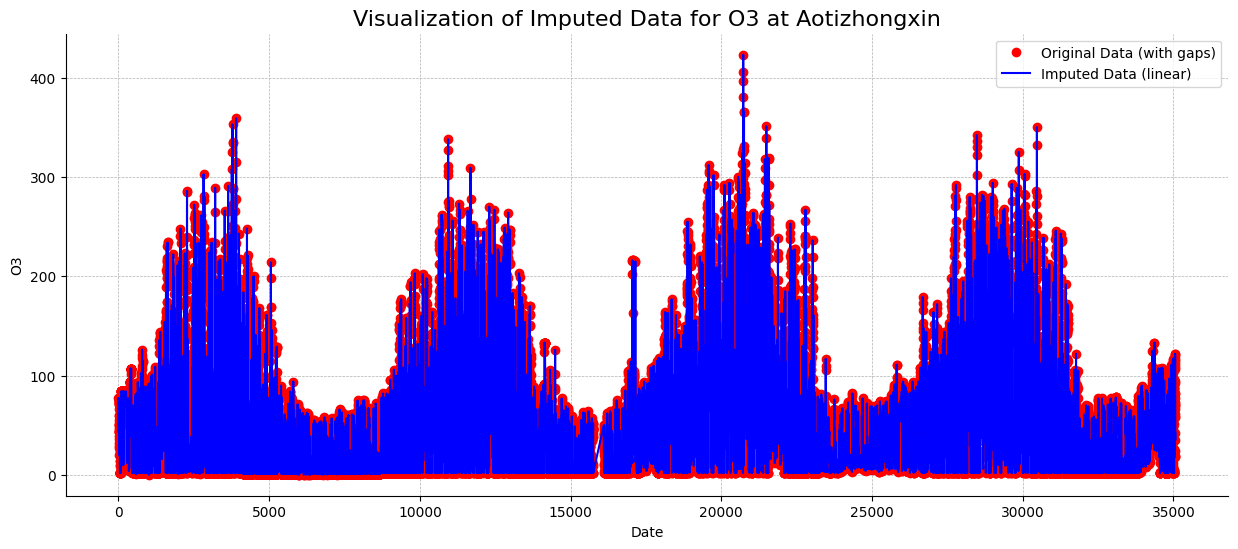

In [14]:
# Select the data for O3 at the Aotizhongxin station
station = 'Aotizhongxin'
column = 'O3'
df_o3 = df[df['station'] == station][column]

# --- Visualization for O3 ---
plt.figure(figsize=(15, 6))

# Plot the original data (with NaN gaps).
# We plot it as a line with markers to highlight where data points exist.
plt.plot(df_o3, marker='o', linestyle='None', color='red', label='Original Data (with gaps)')

# Apply Spline Interpolation to fill the gaps
df_o3_interpolated = df_o3.interpolate(method='linear')

# Plot the interpolated data as a continuous line
plt.plot(df_o3_interpolated, color='blue', label='Imputed Data (linear)')

plt.title(f'Visualization of Imputed Data for {column} at {station}', fontsize=16)
plt.xlabel('Date')
plt.ylabel(column)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


Based on the graph we've provided, the interpolation for O3 looks very good and appears to be a reasonable way to handle the missing data.

1. **Effective Filling of Gaps:** The blue line (the imputed data) smoothly and logically fills in all the gaps where the red dots (the original data) are missing. This is exactly what you want from an imputation method.

2. **Preservation of Diurnal Pattern:** The plot clearly shows the daily cycle of O3 concentration—levels rise during the day and fall at night. The interpolated line successfully follows this pattern, suggesting that the linear method is well-suited to capturing the non-linear, periodic nature of this variable.

3. **Smoothness and Continuity:** The interpolated line is smooth and doesn't introduce any sudden, unrealistic spikes or drops. It provides a continuous and believable connection between the existing data points.

4. **No Extraneous Values:** The filled-in values stay within the expected range of the surrounding data, which is a key indicator that the interpolation is not creating any artificial outliers.

In conclusion, the visualization confirms that the chosen interpolation method is a very good fit for the O3 data. The imputed values are reasonable and do not appear to be skewing the key temporal patterns of the pollutant.

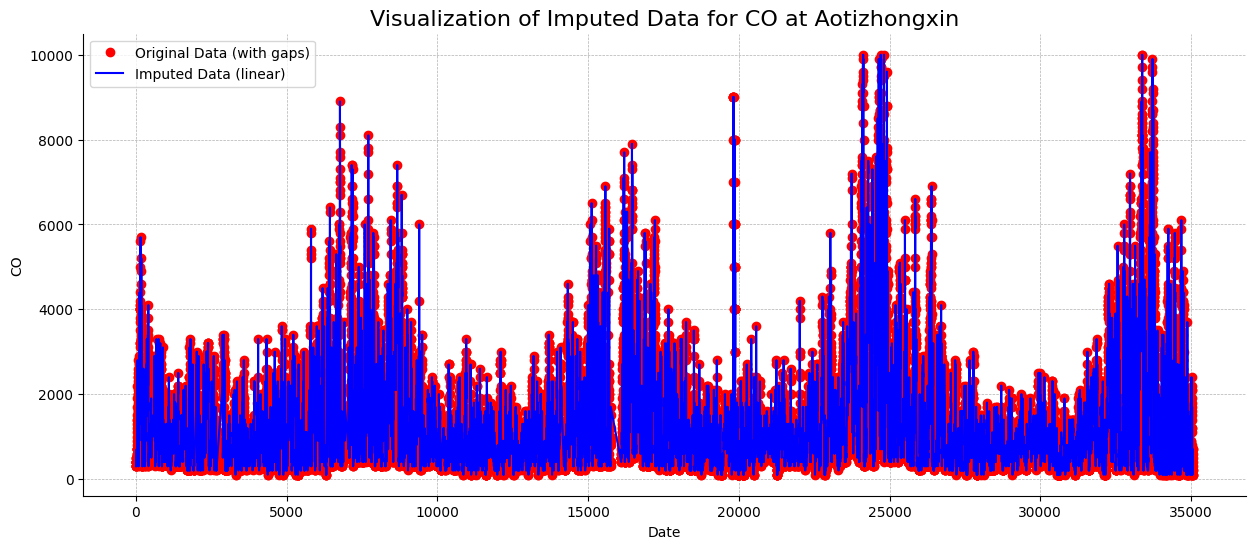

In [15]:
# Select the data for CO at the Aotizhongxin station
station = 'Aotizhongxin'
column = 'CO'
df_CO = df[df['station'] == station][column]

# --- Visualization for O3 ---
plt.figure(figsize=(15, 6))

# Plot the original data (with NaN gaps).
# We plot it as a line with markers to highlight where data points exist.
plt.plot(df_CO, marker='o', linestyle='None', color='red', label='Original Data (with gaps)')

# Apply Spline Interpolation to fill the gaps
df_CO_interpolated = df_CO.interpolate(method='linear')

# Plot the interpolated data as a continuous line
plt.plot(df_CO_interpolated, color='blue', label='Imputed Data (linear)')

plt.title(f'Visualization of Imputed Data for {column} at {station}', fontsize=16)
plt.xlabel('Date')
plt.ylabel(column)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [16]:
# Step 1: Group by 'station' and apply interpolation to each group
# This is the key step. We interpolate each station's time series independently.

interpolated_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

df_imputed = df.groupby('station')[interpolated_cols].apply(
    lambda x: x.interpolate(method='linear')
)

print("Interpolation complete.")

Interpolation complete.


In [17]:
df_imputed.describe()

PM2.5           PM10            SO2            NO2  \
count  420768.000000  420768.000000  420768.000000  420746.000000   
mean       79.839718     104.910268      15.913090      50.601416   
std        80.950217      92.431422      21.896609      35.171276   
min         2.000000       2.000000       0.285600       1.026500   
25%        20.000000      36.000000       3.000000      23.000000   
50%        55.000000      82.000000       7.000000      43.000000   
75%       111.000000     145.000000      20.000000      71.000000   
max       999.000000     999.000000     500.000000     290.000000   

                  CO             O3  
count  420768.000000  420768.000000  
mean     1235.682649      57.237872  
std      1161.790893      57.135195  
min       100.000000       0.214200  
25%       500.000000      10.000000  
50%       900.000000      44.000000  
75%      1500.000000      82.000000  
max     10000.000000    1071.000000

After groupby().apply(), the result has a multi-index (station, original index).

Resetting with drop=True keeps only the original index, so it lines up with df properly.

In [18]:
df_imputed = df_imputed.reset_index(level=0, drop=True)

In [19]:
df.update(df_imputed)

In [20]:
df

No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0          1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1          2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2          3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3          4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4          5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
35059  35060  2017      2   28    19   11.0  32.0   3.0  24.0  400.0  72.0   
35060  35061  2017      2   28    20   13.0  32.0   3.0  41.0  500.0  50.0   
35061  35062  2017      2   28    21   14.0  28.0   4.0  38.0  500.0  54.0   
35062  35063  2017      2   28    22   12.0  23.0   4.0  30.0  400.0  59.0   
35063  35064  2017      2   28    23   13.0  19.0   4.0  38.0  600.0  49.0   

       TEMP    PRES  DEWP  RAIN  WSPM   station  wd_degrees  wd_E  wd_ENE  \
0      -0.7  1023.0 -18.8   0.0   4.4  Guanyuan       337.5     0       0   
1      -1.1  1023.2 -18.2   0.0   4.7  Guanyuan         0.0     0       0   
2      -1.1  1023.5 -18.2   0.0   5.6  Guanyuan       337.5     0       0   
3      -1.4  1024.5 -19.4   0.0   3.1  Guanyuan       315.0     0       0   
4      -2.0  1025.2 -19.5   0.0   2.0  Guanyuan         0.0     0       0   
...     ...     ...   ...   ...   ...       ...         ...   ...     ...   
35059  12.5  1013.5 -16.2   0.0   2.4    Dongsi       315.0     0       0   
35060  11.6  1013.6 -15.1   0.0   0.9    Dongsi       292.5     0       0   
35061  10.8  1014.2 -13.3   0.0   1.1    Dongsi       315.0     0       0   
35062  10.5  1014.4 -12.9   0.0   1.2    Dongsi       337.5     0       0   
35063   8.6  1014.1 -15.9   0.0   1.3    Dongsi        22.5     0       0   

       wd_ESE  wd_N  wd_NE  wd_NNE  wd_NNW  wd_NW  wd_S  wd_SE  wd_SSE  \
0           0     0      0       0       1      0     0      0       0   
1           0     1      0       0       0      0     0      0       0   
2           0     0      0       0       1      0     0      0       0   
3           0     0      0       0       0      1     0      0       0   
4           0     1      0       0       0      0     0      0       0   
...       ...   ...    ...     ...     ...    ...   ...    ...     ...   
35059       0     0      0       0       0      1     0      0       0   
35060       0     0      0       0       0      0     0      0       0   
35061       0     0      0       0       0      1     0      0       0   
35062       0     0      0       0       1      0     0      0       0   
35063       0     0      0       1       0      0     0      0       0   

       wd_SSW  wd_SW  wd_W  wd_WNW  wd_WSW  
0           0      0     0       0       0  
1           0      0     0       0       0  
2           0      0     0       0       0  
3           0      0     0       0       0  
4           0      0     0       0       0  
...       ...    ...   ...     ...     ...  
35059       0      0     0       0       0  
35060       0      0     0       1       0  
35061       0      0     0       0       0  
35062       0      0     0       0       0  
35063       0      0     0       0       0  

[420768 rows x 34 columns]

for linear method

In [21]:
# for 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'  columns we will use ffill method

columns_to_ffill = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Apply ffill() to the specified columns, grouped by station
df.update(df.groupby('station')[columns_to_ffill].ffill())

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420768 entries, 0 to 35063
Data columns (total 34 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   No          420768 non-null  int64  
 1   year        420768 non-null  int64  
 2   month       420768 non-null  int64  
 3   day         420768 non-null  int64  
 4   hour        420768 non-null  int64  
 5   PM2.5       420768 non-null  float64
 6   PM10        420768 non-null  float64
 7   SO2         420768 non-null  float64
 8   NO2         420768 non-null  float64
 9   CO          420768 non-null  float64
 10  O3          420768 non-null  float64
 11  TEMP        420768 non-null  float64
 12  PRES        420768 non-null  float64
 13  DEWP        420768 non-null  float64
 14  RAIN        420768 non-null  float64
 15  WSPM        420768 non-null  float64
 16  station     420768 non-null  object 
 17  wd_degrees  420768 non-null  float64
 18  wd_E        420768 non-null  int64  
 19  wd_ENE  

Columns Included (PM2.5, PM10, SO2, NO2, CO, O3, RAIN, WSPM)
- Pollutants (PM2.5, PM10, SO2, NO2, CO, O3): These are concentrations of substances in the air. **A concentration of a substance cannot be a negative value**.

- RAIN (Rainfall): **The amount of rainfall can't be negative**.

- WSPM (Wind Speed): **Wind speed is a magnitude and cannot be a negative value**.

Columns Not Included (TEMP, DEWP, PRES, wd, station)
- TEMP (Temperature): **Temperature can absolutely be negative, especially in Beijing's winter**. Applying clip(lower=0) would incorrectly set all sub-zero temperatures to zero, which would severely distort the data.

- DEWP (Dew Point): **The dew point temperature can also be negative**.

- PRES (Pressure): **While atmospheric pressure is always positive, it is a very large number, and interpolation is extremely unlikely to produce a negative value. Therefore, clipping it is not strictly necessary**.

- wd (Wind Direction) & station: **These are not numerical columns**. wd is a categorical variable (e.g., 'NNW', 'N'), and station is a string identifier. The clip() function only works on numerical data, so it cannot be applied to these columns.

## AQI(Air Quality Index) Calculation

The China MEP standard (HJ 633-2012) is the official guideline used by the Ministry of Environmental Protection in China to calculate the Air Quality Index. For each pollutant, an individual score (IAQI) is calculated using a piecewise linear formula based on its concentration. The final AQI reported is simply the highest of these individual scores.

Beside AQI, we will get two more products in this part.
- **Major Pollutant:** The pollutant that yields this highest score is identified as the "Major Pollutant."
- **AQI Category:** Uses the overall AQI to look up and assign the corresponding air quality aqi_category from the categories table.

In [23]:
'''
Unit Conversion for CO: The most critical step for you is to ensure your CO column is in mg/m³. The Beijing dataset often provides it in µg/m³.
You must divide the CO column by 1000 before applying this function.
'''
df['CO'] = df['CO'] / 1000

In [24]:
def calculate_aqi_china_mep(row):
    """
    Calculates AQI and Major Pollutant using China's MEP standard.
    This function expects CO in mg/m³ and other pollutants in µg/m³.
    """
    # Breakpoint table for China's AQI standard (HJ 633-2012)
    pollutants = {
        'PM2.5': [
            (0, 35, 0, 50), (35, 75, 50, 100), (75, 115, 100, 150),
            (115, 150, 150, 200), (150, 250, 200, 300), (250, 350, 300, 400),
            (350, 500, 400, 500)
        ],
        'PM10': [
            (0, 50, 0, 50), (50, 150, 50, 100), (150, 250, 100, 150),
            (250, 350, 150, 200), (350, 420, 200, 300), (420, 500, 300, 400),
            (500, 600, 400, 500)
        ],
        'SO2': [
            (0, 150, 0, 50), (150, 500, 50, 100), (500, 650, 100, 150),
            (650, 800, 150, 200), (800, 1600, 200, 300), (1600, 2100, 300, 400),
            (2100, 2620, 400, 500)
        ],
        'NO2': [
            (0, 100, 0, 50), (100, 200, 50, 100), (200, 700, 100, 150),
            (700, 1200, 150, 200), (1200, 2340, 200, 300), (2340, 3090, 300, 400),
            (3090, 3840, 400, 500)
        ],
        # Correct CO breakpoints expecting mg/m³
        'CO': [
            (0, 5, 0, 50), (5, 10, 50, 100), (10, 35, 100, 150),
            (35, 60, 150, 200), (60, 90, 200, 300), (90, 120, 300, 400),
            (120, 150, 400, 500)
        ],
        'O3': [ # Refers to 8-hour average
            (0, 160, 0, 50), (160, 200, 50, 100), (200, 300, 100, 150),
            (300, 400, 150, 200), (400, 800, 200, 300), (800, 1000, 300, 400),
            (1000, 1200, 400, 500)
        ]
    }
    # AQI category table (China HJ 633-2012)
    categories = [
            (0, 50, "Good"),
            (51, 100, "Moderate"),
            (101, 150, "Unhealthy (SG)"),
            (151, 200, "Unhealthy"),
            (201, 300, "Very Unhealthy"),
            (301, 500, "Hazardous")
    ]

    sub_indices = {}

    # Calculate sub-index for each pollutant present in the row
    for pollutant, ranges in pollutants.items():
        # Check if the pollutant data exists and is not NaN
        if pollutant not in row or pd.isna(row[pollutant]):
            continue

        concentration = row[pollutant]
        iaqi = 0

        # Find the correct range and calculate the sub-index
        for bp_low, bp_high, i_low, i_high in ranges:
            if bp_low <= concentration < bp_high:
                iaqi = ((i_high - i_low) / (bp_high - bp_low)) * (concentration - bp_low) + i_low
                break
        # Handle concentrations above the highest defined range
        else:
             if concentration >= ranges[-1][1]:
                iaqi = ranges[-1][3] # Cap at the highest AQI value in the table

        if iaqi > 0:
            sub_indices[pollutant] = round(iaqi)

    if not sub_indices:
        return 0, 'N/A', 'N/A' # No data to calculate

    # The final AQI is the maximum of the sub-indices
    major_pollutant = max(sub_indices, key=sub_indices.get)
    aqi = sub_indices[major_pollutant]

    # Find category
    aqi_category = "Out of Range"
    for low, high, label in categories:
        if low <= aqi <= high:
            aqi_category = label
            break

    return aqi, major_pollutant , aqi_category

In [25]:
df[['aqi', 'majorPollutant', 'aqi_category']] = df.apply(calculate_aqi_china_mep, axis=1, result_type='expand')

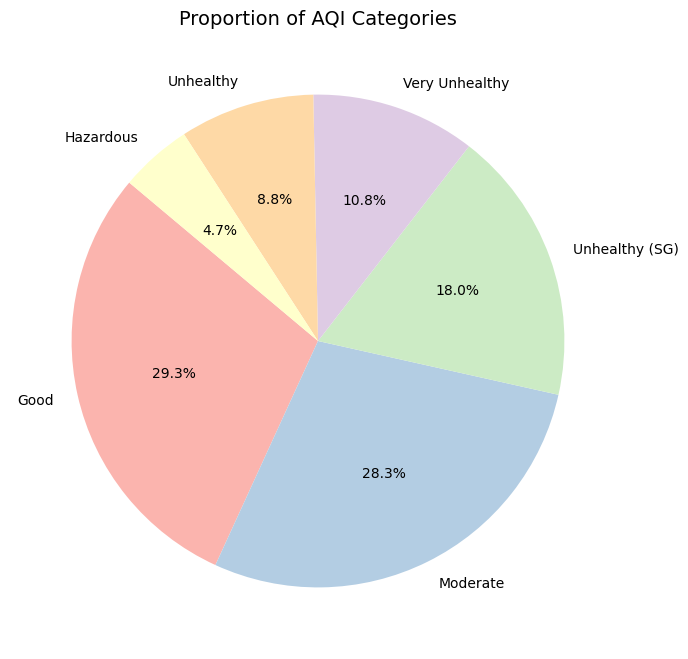

In [26]:
# Proportion of different Air Quality Index (AQI) categories.
plt.figure(figsize=(8,8))
df['aqi_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel1.colors
)

plt.title("Proportion of AQI Categories", fontsize=14)
plt.ylabel("")  # remove y-label
plt.show()

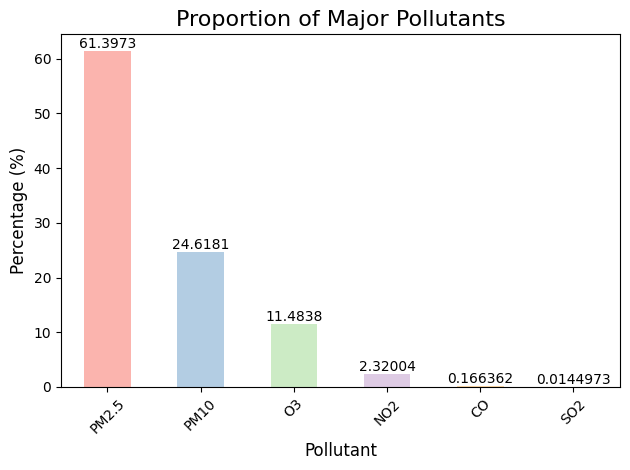

In [27]:
# 1. Get the value counts as percentages
pollutant_percentages = df['majorPollutant'].value_counts(normalize=True) * 100

# 2. Create the bar plot
ax = pollutant_percentages.plot(
    kind='bar',
    color=sns.color_palette('Pastel1', len(pollutant_percentages))
)

# 3. Add count labels on top of each bar for clarity
for container in ax.containers:
    ax.bar_label(container)

# 4. Set titles and labels
plt.title("Proportion of Major Pollutants", fontsize=16)
plt.xlabel("Pollutant", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45) # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

- The two charts above reveal two key insights: **PM2.5** is the dominant pollutant by mass (61.4%), and the air quality is frequently unhealthy (over 40% of the time). This strongly suggests that accurately forecasting PM2.5 will be the most critical part of our project.

- Our primary goal should be to predict the numerical concentration of PM2.5. The first chart makes it clear that this pollutant is the biggest contributor to the overall pollution. A good PM2.5 forecast will likely lead to a good overall Air Quality Index (AQI) forecast.

- Alternatively, we can directly predict the numerical AQI value, which allows a model to learn the combined effects of all pollutants and weather conditions.

To predict future pollution, your model needs historical context. The most important features will be:

**Lag Features:** The pollution level right now is the best predictor of the pollution level in the next hour. Create features from previous time steps (e.g., PM2.5 from 1 hour ago, 3 hours ago, 24 hours ago).

**Meteorological Data:** Pollution is heavily driven by weather. You must include features like wind speed, wind direction, temperature, and humidity. These are essential for predicting how pollutants will accumulate or disperse.

**Temporal Features:** Create features that capture time-based patterns, such as the hour of the day (for traffic cycles), the day of the week (for work vs. weekend patterns), and the month or season (for heating or ozone seasons).

majorPollutant
PM2.5    18655
PM10      1257
O3          16
Name: count, dtype: int64


Text(0.5, 1.0, 'Proportion of pollutant_counts')

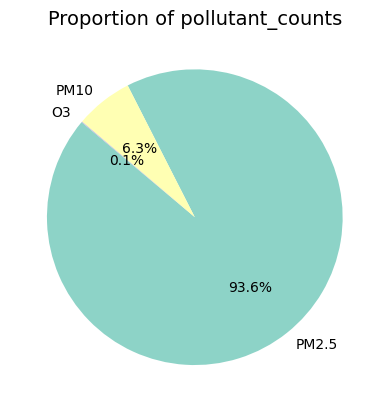

In [28]:
# Filter only hazardous rows
hazardous_data = df[df["aqi_category"] == "Hazardous"]

# Count frequency of each major pollutant
pollutant_counts = hazardous_data["majorPollutant"].value_counts()

print(pollutant_counts)
plt.pie(
    pollutant_counts,
    labels=pollutant_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)

plt.title("Proportion of pollutant_counts", fontsize=14)

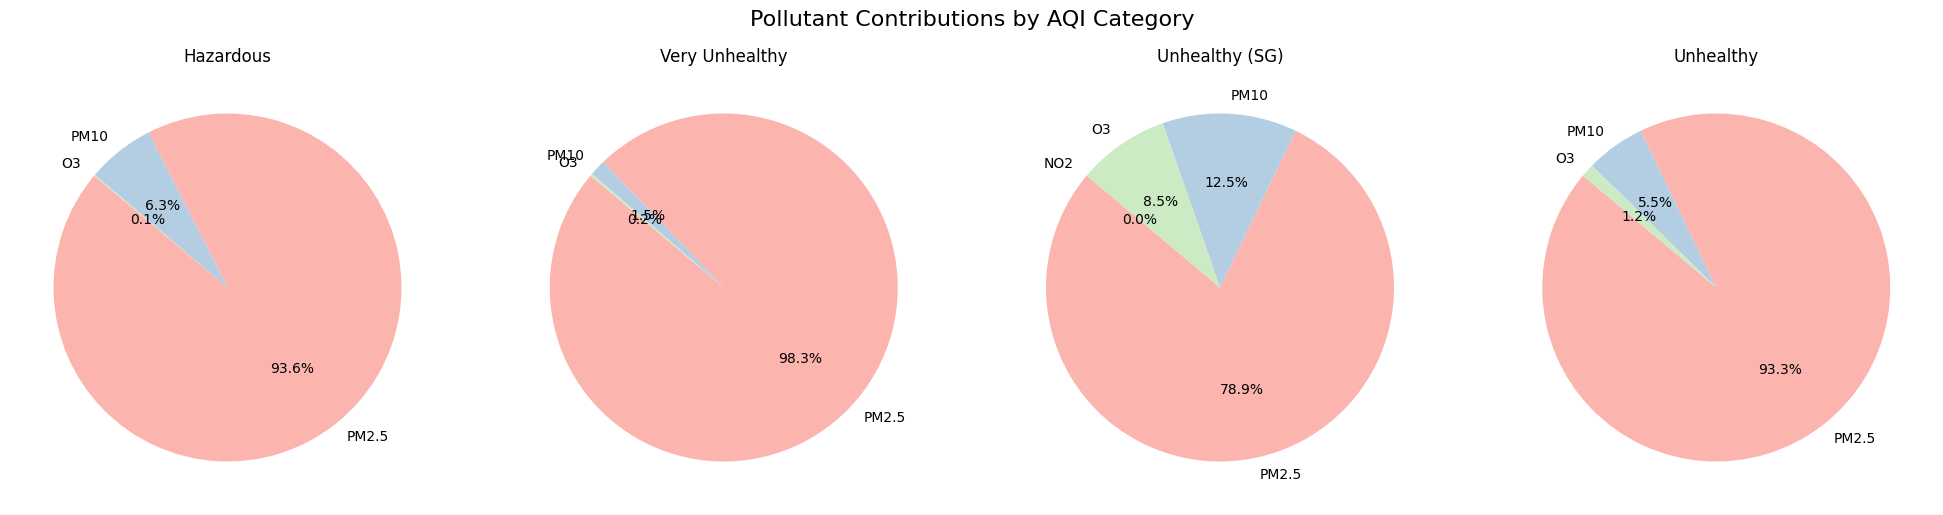

In [29]:
# which pollutants are primarily responsible for different levels of unhealthy air.
import matplotlib.pyplot as plt

categories = ["Hazardous", "Very Unhealthy", "Unhealthy (SG)", "Unhealthy"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

for i, cat in enumerate(categories):
    ax = axes[i]

    # Filter by category and count pollutants
    counts = df[df['aqi_category'] == cat]['majorPollutant'].value_counts()

    # Plot pie chart
    counts.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        ax=ax
    )

    ax.set_title(cat, fontsize=12)
    ax.set_ylabel("")  # remove default ylabel

plt.suptitle("Pollutant Contributions by AQI Category", fontsize=16, y=1.02) # Adjusted y parameter
plt.tight_layout()
plt.show()

In [30]:
# Step 1: Create a single datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.drop(columns=['year', 'month', 'day', 'hour', 'No'])

# Create a single datetime index
df.set_index('datetime', inplace=True)
df = df.sort_index()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420768 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PM2.5           420768 non-null  float64
 1   PM10            420768 non-null  float64
 2   SO2             420768 non-null  float64
 3   NO2             420768 non-null  float64
 4   CO              420768 non-null  float64
 5   O3              420768 non-null  float64
 6   TEMP            420768 non-null  float64
 7   PRES            420768 non-null  float64
 8   DEWP            420768 non-null  float64
 9   RAIN            420768 non-null  float64
 10  WSPM            420768 non-null  float64
 11  station         420768 non-null  object 
 12  wd_degrees      420768 non-null  float64
 13  wd_E            420768 non-null  int64  
 14  wd_ENE          420768 non-null  int64  
 15  wd_ESE          420768 non-null  int64  
 16  wd_N            420768

In [32]:
# Define the paths in Google Drive

pkl_path = '/content/drive/MyDrive/beijing_air_processed.pkl'
#csv_path = '/content/drive/MyDrive/beijing_air_processed.csv'


# Check if Drive is mounted, if not, mount it (just in case)
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# Save as Pickle (Best for preserving pandas data types, indexes, and categories)
df.to_pickle(pkl_path)
print(f"DataFrame saved to Pickle at: {pkl_path}")

# Save as CSV (Good for general viewing and compatibility)
#df.to_csv(csv_path)
#print(f"DataFrame saved to CSV at: {csv_path}")

DataFrame saved to Pickle at: /content/drive/MyDrive/beijing_air_processed.pkl


### Subtask:
Create relevant features from the time series data such as lagged, rolling and time-based features.


## Lag Features (Short-Term Memory)

### Hour of The Day

In [33]:
# Create a new column that contains the PM2.5 value from 24 hours ago for each station
df['pm25_lag_24h'] = df.groupby('station')['PM2.5'].shift(24)

In [34]:
# Define the rush hour periods
morning_rush = [7, 8, 9]      # 7:00 - 9:59 AM
evening_rush = [17, 18, 19] # 5:00 - 7:59 PM
night = [20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]
day = [10, 11, 12, 13, 14, 15, 16]
# Get the hour from the index
hour_of_day = df.index.hour

# Create a new column to categorize the time of day
def assign_traffic_period(hour):
    if hour in morning_rush:
        return 'Morning_Rush'
    elif hour in evening_rush:
        return 'Evening_Rush'
    elif hour in night:
        return 'Night'
    else:
        return 'Day'

# Apply the function to create the feature
df['traffic_period'] = [assign_traffic_period(h) for h in hour_of_day]

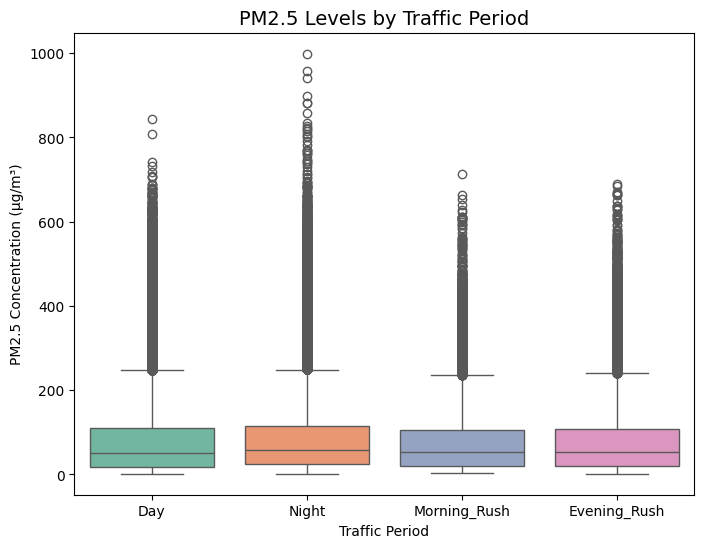

In [35]:
# visualizing how PM2.5 pollution levels vary during different times of the day.
plt.figure(figsize=(8,6))
sns.boxplot(x='traffic_period', y='PM2.5', data=df, palette='Set2', hue='traffic_period', legend=False )

plt.title("PM2.5 Levels by Traffic Period", fontsize=14)
plt.xlabel("Traffic Period")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.show()


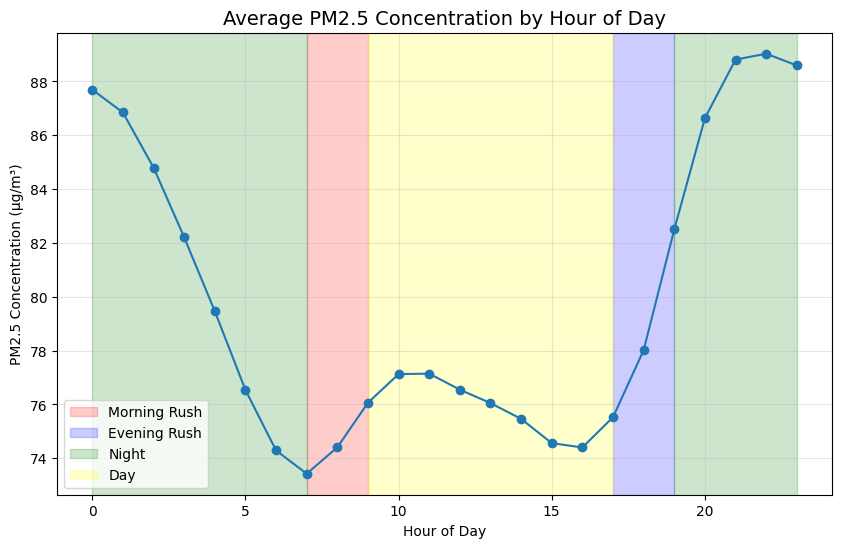

In [36]:
plt.figure(figsize=(10,6))

# Group by hour of day
hourly_mean = df.groupby(df.index.hour)['PM2.5'].mean()

plt.plot(hourly_mean.index, hourly_mean.values, marker='o', linestyle='-')
plt.axvspan(7, 9, color='red', alpha=0.2, label="Morning Rush")
plt.axvspan(17, 19, color='blue', alpha=0.2, label="Evening Rush")
plt.axvspan(19, 23, color='green', alpha=0.2, label="Night")
plt.axvspan(0, 7, color='green', alpha=0.2)  # same label not repeated
plt.axvspan(9, 17, color='yellow', alpha=0.2, label="Day")

plt.title("Average PM2.5 Concentration by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


📌 Interpretation

**Daily cycle:** PM2.5 follows a U-shape → high at night, low in the early morning, and rising again in the evening.

**Rush hour effect:**

- Evening rush clearly increases PM2.5.

- Morning rush doesn’t spike as much, likely because early-day atmospheric conditions disperse pollutants better.

**Key concern:** The highest pollution levels are at night, not during rush hours. This could have health implications for people with nighttime outdoor exposure or overnight activities.

In [37]:
df['hour_sin'] = np.sin(2 * np.pi * (df.index.hour + 6) / 24)
df['hour_cos'] = np.cos(2 * np.pi * (df.index.hour + 6) / 24)

### Day of The Week and Weekend Features

In [38]:
# Create a column for the day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df.index.dayofweek

# Create a binary feature for weekends
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [39]:
# 2. Calculate the average PM2.5 for each hour, separated by weekday/weekend
# We group by both the 'is_weekend' flag and the hour of the day
avg_pm25_by_hour = df.groupby(['is_weekend', df.index.hour])['PM2.5'].mean()

# 3. Separate the aggregated data into two series for plotting
weekday_avg = avg_pm25_by_hour.loc[0] # weekend = 0
weekend_avg = avg_pm25_by_hour.loc[1] # weekend = 1

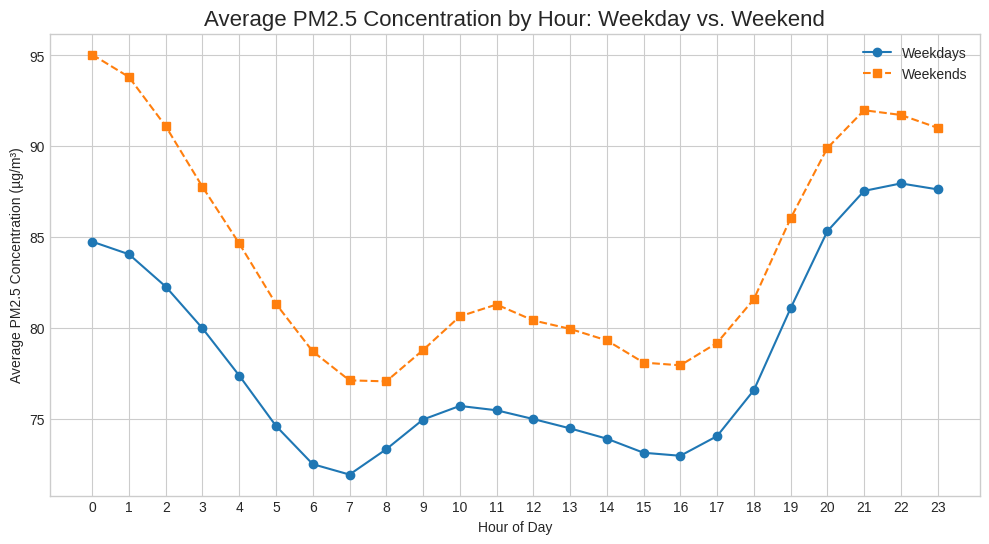

In [40]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 6))

plt.plot(weekday_avg.index, weekday_avg.values, marker='o', linestyle='-', label='Weekdays')
plt.plot(weekend_avg.index, weekend_avg.values, marker='s', linestyle='--', label='Weekends')

# Add titles and labels for clarity
plt.title('Average PM2.5 Concentration by Hour: Weekday vs. Weekend', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5 Concentration (µg/m³)')
plt.xticks(range(0, 24)) # Ensure all hours are marked on the x-axis
plt.legend()
plt.show()

**Weekdays cycle:** PM2.5 follows a U-shape → high at weekend, low in the weekdays.

### 7 Days Rolling mean

In [41]:
df['pm25_rolling_7d_mean']  = df.groupby('station')['PM2.5'].transform(lambda x: x.rolling(24*7).mean().shift(1)) #also 7D can be used for 24*7

- Keeps your original frequency (hourly rows stay hourly).

- At each row, computes a mean over the last N rows (or time span if using rolling('7D')).

- .shift(1) → moves that value one step down, so each time point uses the previous window’s mean. **At time t**, the value shows the average of the past 7 days up to **t−1**, not including the current hour.

- This is especially important if you’re using this as a feature for prediction, so you don’t **“leak” future information** into your model.

**there’s a big conceptual difference between resample('W').mean() and rolling (window=...)** we'll see on the upcoming lines...

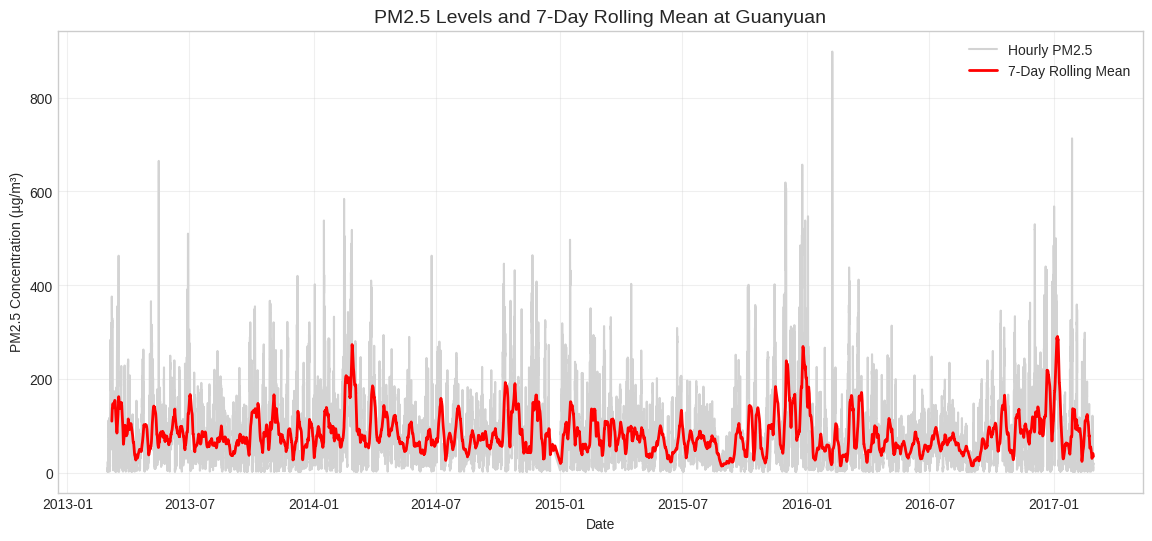

In [42]:
# pick one station to keep the plot readable
station_name = "Guanyuan"   # change to any station in your dataset

df_station = df[df['station'] == station_name]

plt.figure(figsize=(14,6))
plt.plot(df_station.index, df_station['PM2.5'],
         color='lightgray', label='Hourly PM2.5')
plt.plot(df_station.index, df_station['pm25_rolling_7d_mean'],
         color='red', linewidth=2, label='7-Day Rolling Mean')

plt.title(f"PM2.5 Levels and 7-Day Rolling Mean at {station_name}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**multiple stations in subplots**

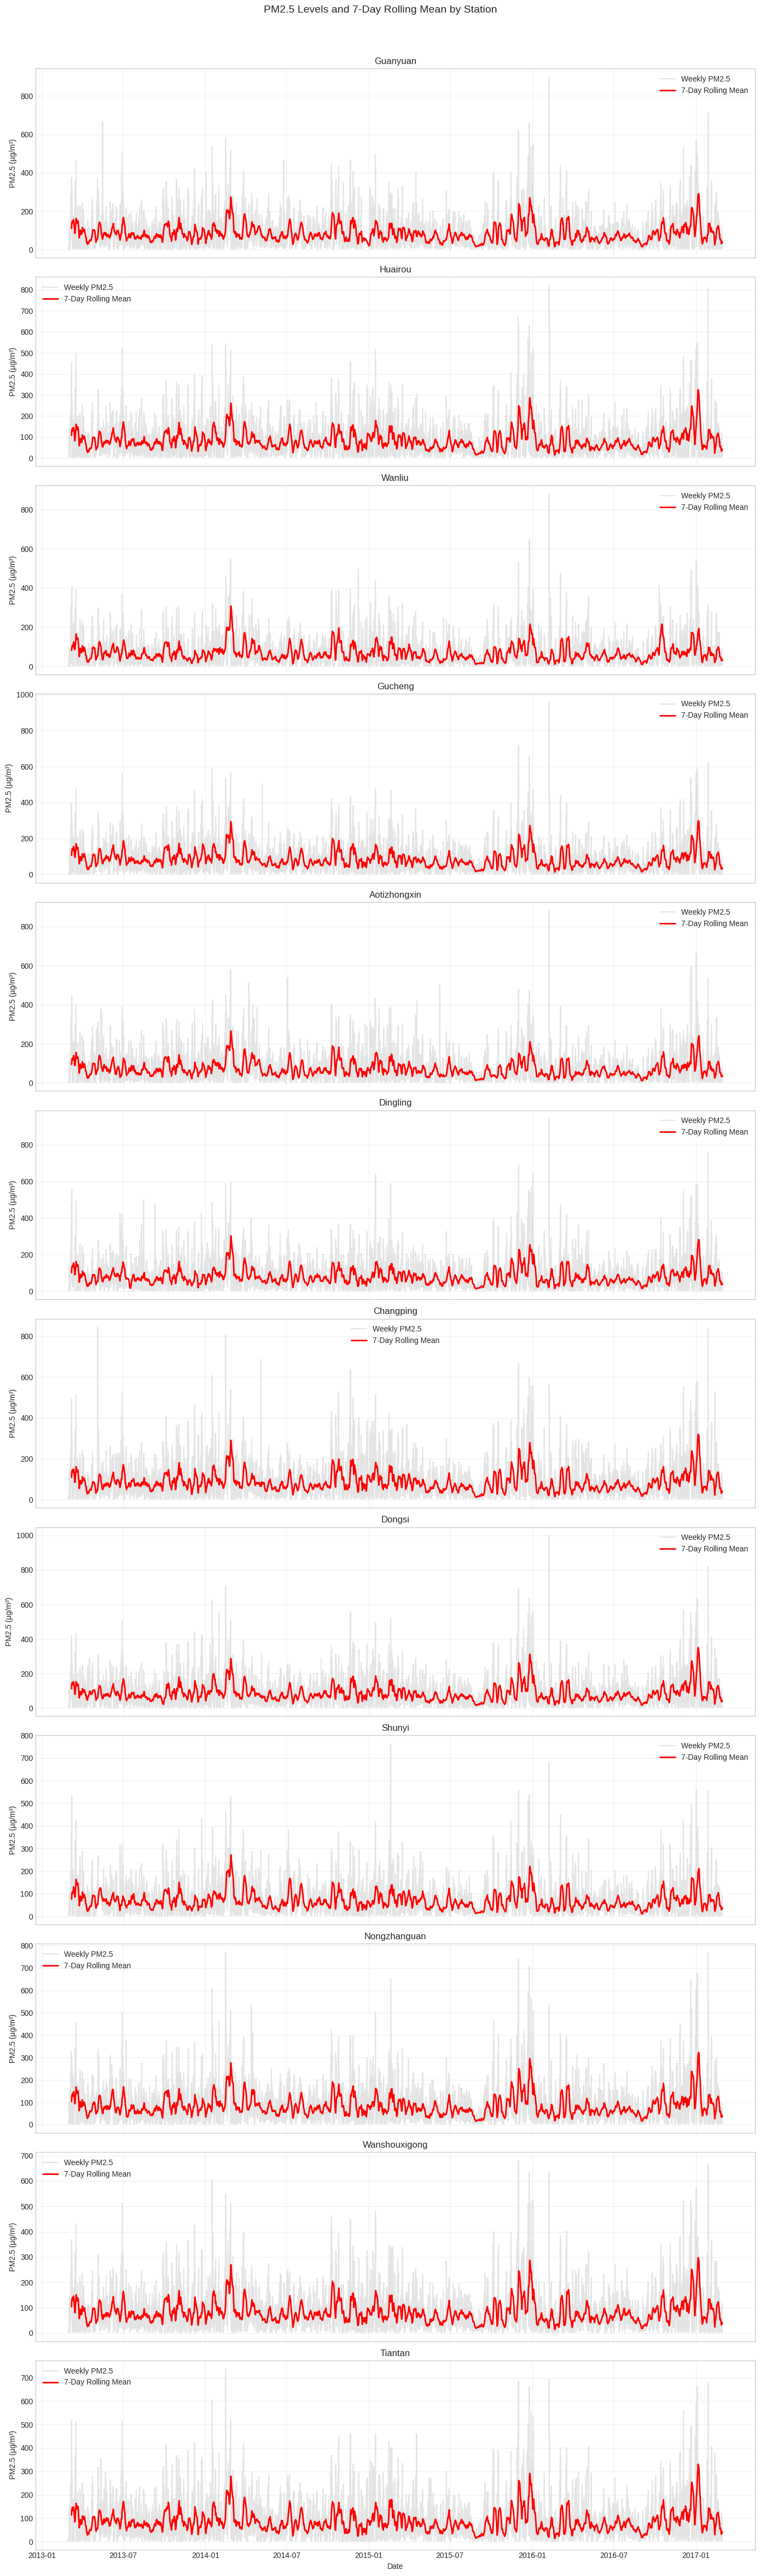

In [43]:
import matplotlib.pyplot as plt

# List of stations to plot (you can select fewer if dataset has many)
stations = df['station'].unique()

# Create subplots (1 row per station)
fig, axes = plt.subplots(len(stations), 1, figsize=(14, 4*len(stations)), sharex=True)

for i, station in enumerate(stations):
    df_station = df[df['station'] == station]

    axes[i].plot(df_station.index, df_station['PM2.5'],
                 color='lightgray', alpha=0.6, label='Weekly PM2.5')
    axes[i].plot(df_station.index, df_station['pm25_rolling_7d_mean'],
                 color='red', linewidth=2, label='7-Day Rolling Mean')

    axes[i].set_title(f"{station}", fontsize=12)
    axes[i].set_ylabel("PM2.5 (µg/m³)")
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.xlabel("Date")
plt.suptitle("PM2.5 Levels and 7-Day Rolling Mean by Station", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### 24 Hours Rolling Mean

In [44]:
df['pm25_rolling_24h_mean'] = df.groupby('station')['PM2.5'].transform(lambda x: x.rolling(24).mean().shift(1))

### 4 Hours Rolling Mean

In [45]:
df['pm25_rolling_4h_mean'] = df.groupby('station')['PM2.5'].transform(lambda x: x.rolling(4).mean().shift(1))

**Possible Reasons for High PM2.5 at the Beginning of the Year**

**1. Winter Weather & Atmospheric Conditions**

   - Cold air → temperature inversions trap pollutants close to the surface, preventing dispersion.

   - Lower wind speeds in winter mean pollutants linger longer.

**2. Heating & Energy Use**

   - In January, many cities rely more on coal, wood, or other fuels for heating → significant source of fine particulates.

**3. Festive Seasons & Fireworks**

   - In China (and some other places), Chinese New Year celebrations (usually Jan/Feb) involve fireworks and firecrackers → huge temporary spikes in PM2.5.

**4. Low Vegetation & Less Photochemistry**

   - In summer, plants absorb some pollutants and stronger sunlight helps break down particles.

   - In winter, vegetation is sparse, and chemical reactions in the atmosphere are weaker → particles accumulate more easily.

### Monthly Features

In [46]:
# 1. Create the 'month' feature from the index
df['month'] = df.index.month
df['is_winter'] = df['month'].isin([11, 12, 1, 2]).astype(int)

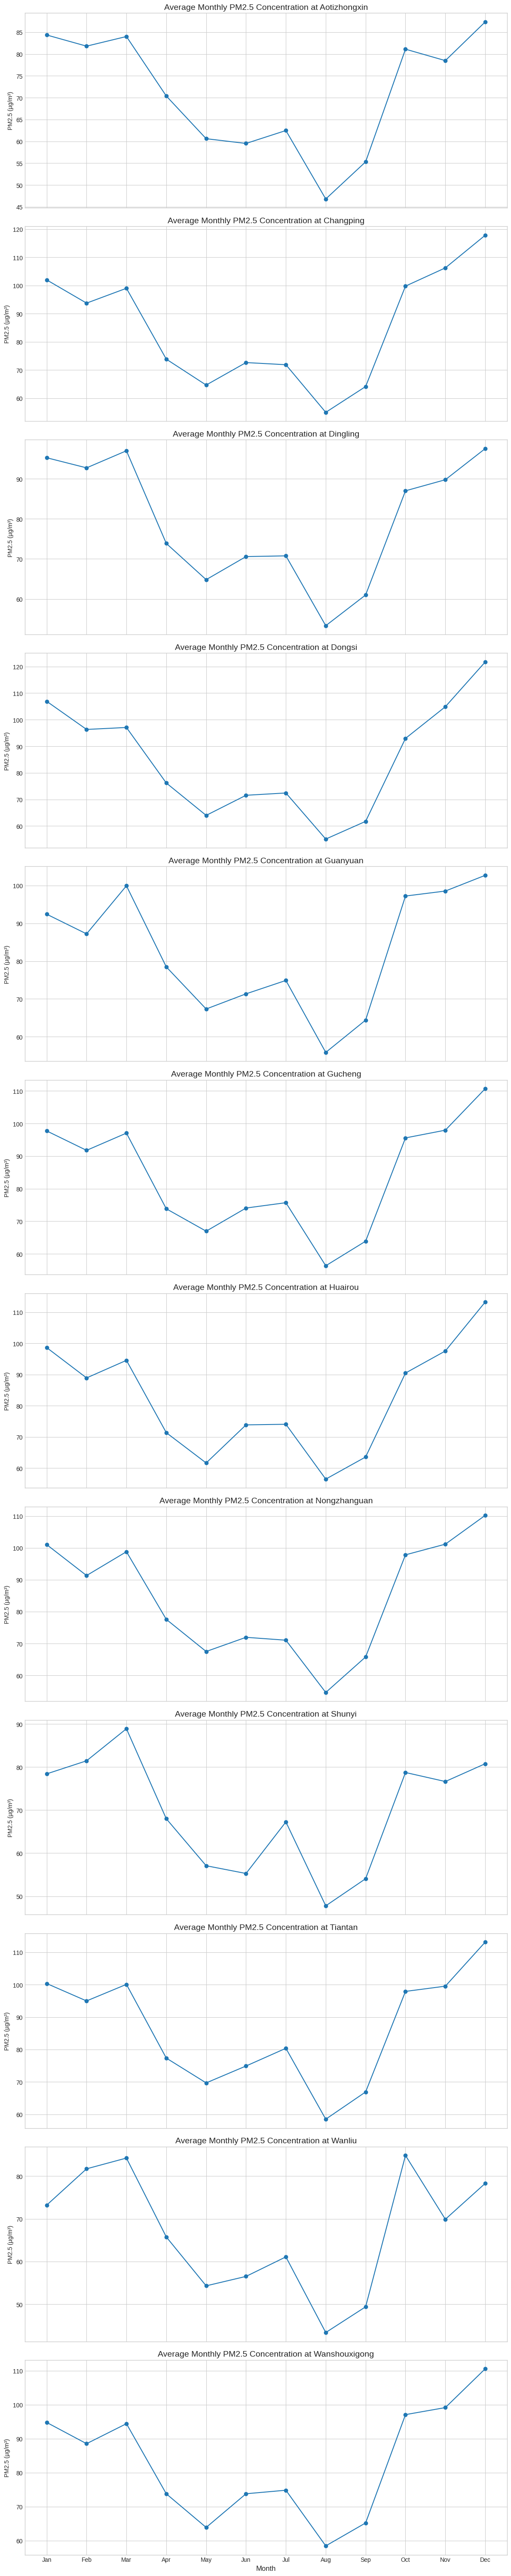

In [47]:
import calendar

# 1. Group by station and month to calculate monthly averages
#df['month'] = df.index.month
monthly_avg_pm25 = df.groupby(['station', 'month'])['PM2.5'].mean().reset_index()

# 2. Get unique stations
stations = monthly_avg_pm25['station'].unique()

# 3. Create subplots (one column, multiple rows)
fig, axes = plt.subplots(len(stations), 1, figsize=(12, 5 * len(stations)), sharex=True)

# If only one station, axes is not an array
if len(stations) == 1:
    axes = [axes]

# 4. Plot for each station
for ax, station in zip(axes, stations):
    station_data = monthly_avg_pm25[monthly_avg_pm25['station'] == station]

    ax.plot(
        station_data['month'],
        station_data['PM2.5'],
        marker='o',
        linestyle='-'
    )
    ax.set_title(f'Average Monthly PM2.5 Concentration at {station}', fontsize=14)
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

# 5. Common X label
plt.xlabel('Month', fontsize=12)

plt.tight_layout()
plt.show()

All stations in one graph

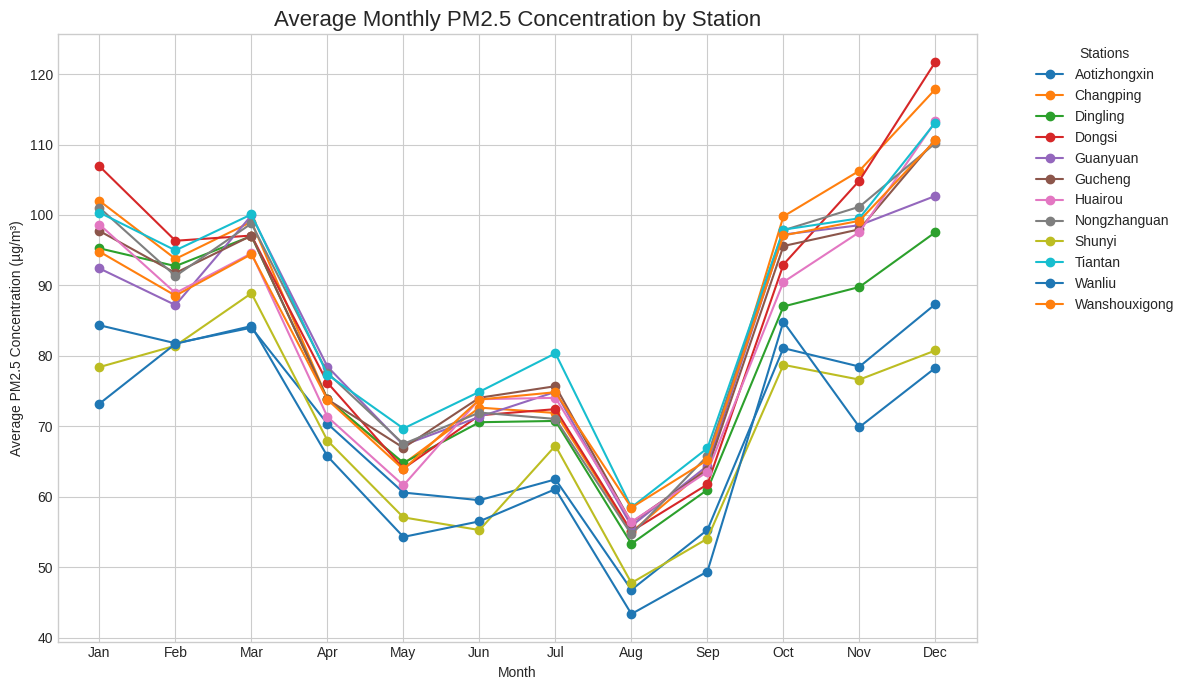

In [48]:
# 1. Extract month
df['month'] = df.index.month

# 2. Group by station and month
monthly_avg_pm25 = df.groupby(['station', 'month'])['PM2.5'].mean().reset_index()

# 3. Create the plot
plt.figure(figsize=(12, 7))

# Plot each station
for station in monthly_avg_pm25['station'].unique():
    station_data = monthly_avg_pm25[monthly_avg_pm25['station'] == station]
    plt.plot(
        station_data['month'],
        station_data['PM2.5'],
        marker='o',
        linestyle='-',
        label=station
    )

# 4. Titles and labels
plt.title('Average Monthly PM2.5 Concentration by Station', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Concentration (µg/m³)')

# 5. Custom X-axis labels
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)])

# Legend
plt.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Yearly Average of The Stations

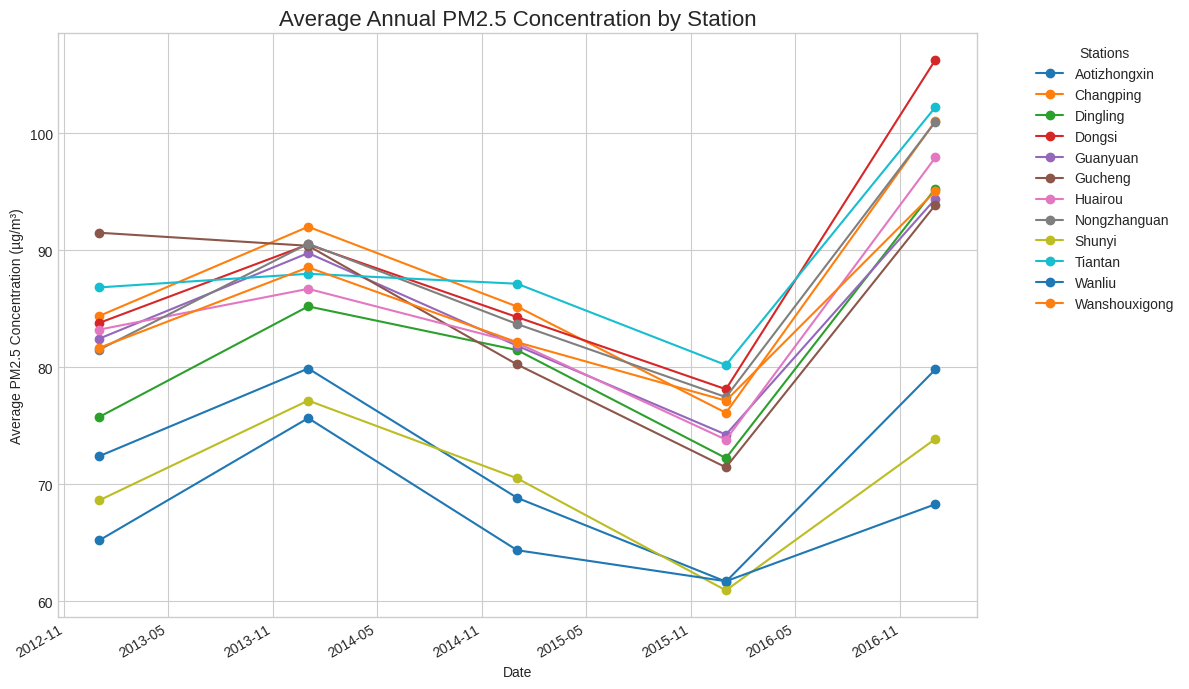

In [49]:
import matplotlib.dates as mdates

# --- 1. Data Preparation: Extract Year and Calculate Annual Mean ---

# 1. Extract year
# Assuming df has a datetime index
df['year'] = df.index.year

# 2. Group by station and year
yearly_avg_pm25 = df.groupby(['station', 'year'])['PM2.5'].mean().reset_index()

# CRITICAL STEP: Convert the integer 'year' back to a datetime object
# This is necessary for matplotlib's date functions (mdates) to work correctly.
yearly_avg_pm25['date'] = pd.to_datetime(yearly_avg_pm25['year'], format='%Y')

# --- 2. Create the Plot ---

plt.figure(figsize=(12, 7))
ax = plt.gca() # Get the current axes for date formatting

# Plot each station
for station in yearly_avg_pm25['station'].unique():
    station_data = yearly_avg_pm25[yearly_avg_pm25['station'] == station]
    plt.plot(
        # Use the new 'date' column (Datetime object) for the x-axis
        station_data['date'],
        station_data['PM2.5'],
        marker='o',
        linestyle='-',
        label=station
    )

# --- 3. Customization and Styling (X-Axis Focus) ---

# Set the major tick locator to every 6 months (January and July)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Set the date format to Year-Month (YYYY-MM)
date_form = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

# Minor ticks for every month (optional, for subtle grid lines)
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Optional: Rotate and align the labels for better fit
plt.gcf().autofmt_xdate()

# Titles and labels
plt.title('Average Annual PM2.5 Concentration by Station', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Average PM2.5 Concentration (µg/m³)')

# Legend
plt.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

## Convert the station column into numeric features

**Alias**	           **Description**

  'H'	          Hourly frequency

  'D'	          Daily frequency

  'W'	          Weekly frequency (ends on Sunday by default)

  'M'	          Month-end frequency

  'MS'	        Month-start frequency

  'Q'	          Quarter-end frequency

  'Y'	          Year-end frequency
  
  'T' or 'min'	Minutely frequency

## Daily For Decomposition

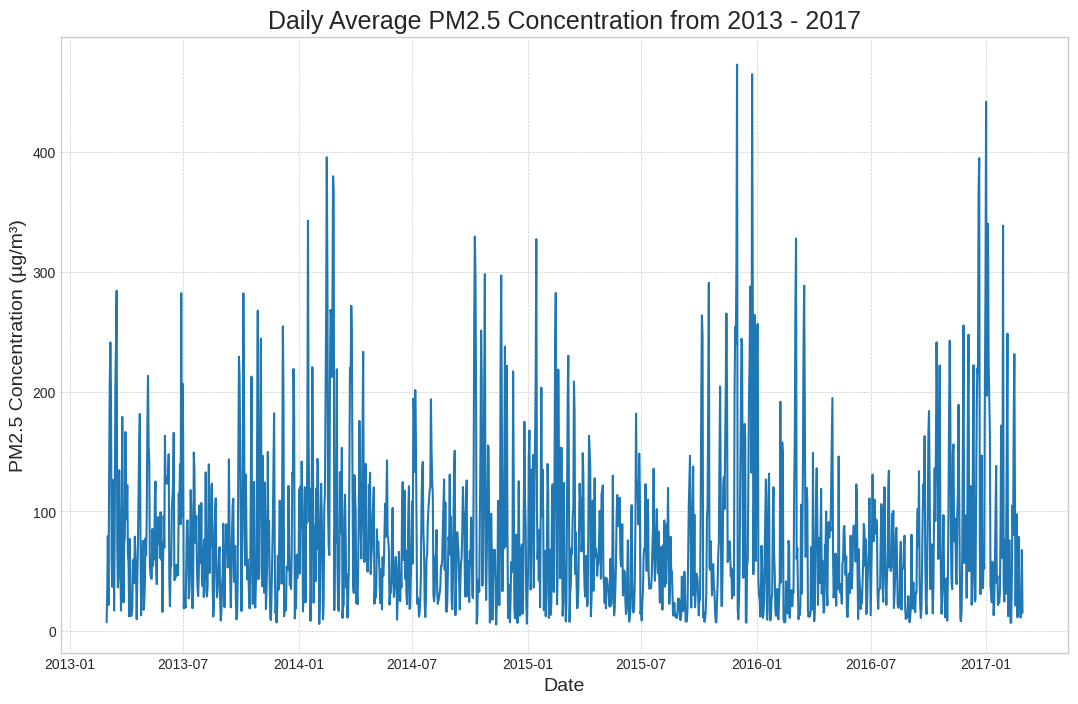

In [50]:
# 1. Resample the PM2.5 data to a daily ('D') frequency, calculating the mean for each day
df_daily = df.resample('D').mean(numeric_only=True)

# 2. Create the plot using the new daily data
plt.figure(figsize=(13, 8))
plt.plot(df_daily.index, df_daily["PM2.5"].values, label="PM2.5 Daily Avg") # Plot the resampled data

# 3. Update the title and fix the y-axis label
plt.title('Daily Average PM2.5 Concentration from 2013 - 2017', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=14) # Corrected typo in label
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

- Downsamples your time series to daily frequency.

- Each row in the new DataFrame corresponds to one whole day.

- For each day, it takes all values in that day and computes the mean.

- The result has fewer rows (one per day), not one per hour.

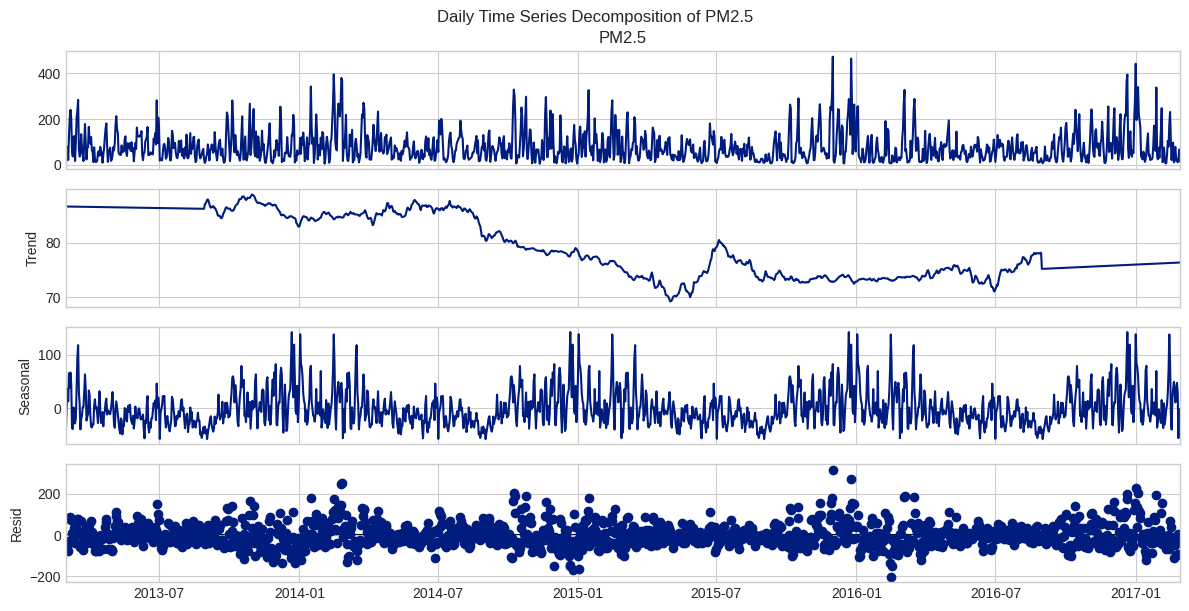

In [51]:
# time series decomposition
plt.style.use('seaborn-v0_8-dark-palette') # Changed to a valid seaborn style
plt.rcParams['figure.figsize'] = (12, 6)

# Set the period to 365 for daily
decomposition = sm.tsa.seasonal_decompose(df_daily["PM2.5"], model='additive', extrapolate_trend='freq', period=365)
fig = decomposition.plot()
plt.suptitle('Daily Time Series Decomposition of PM2.5', y=1.01)
plt.show()

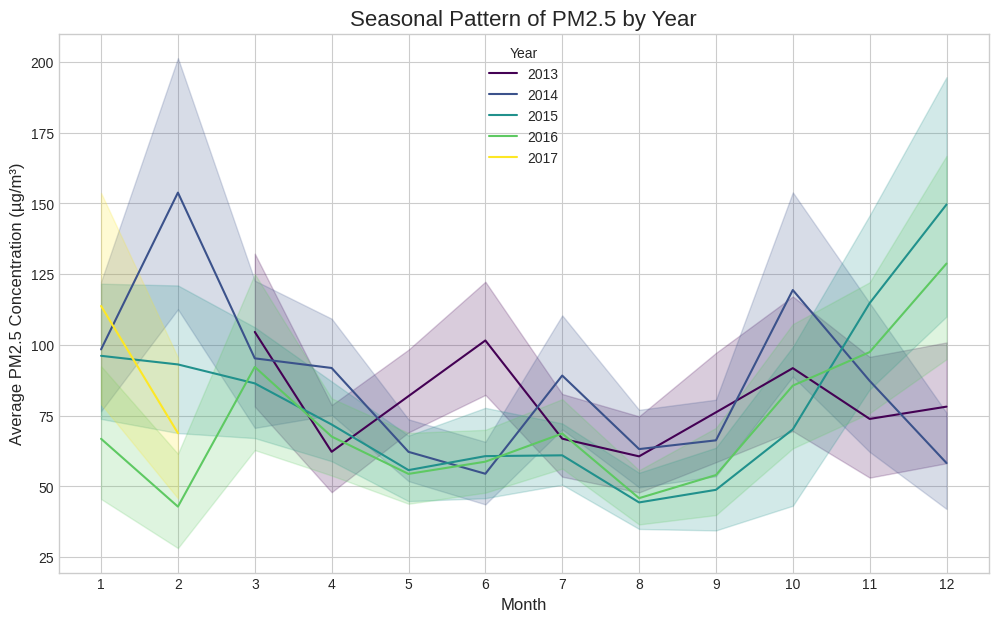

In [52]:
# 1. Resample the data to a daily average to make the plot cleaner

#df_resampled = (df.resample('D').mean(numeric_only=True).assign(year=lambda d: d.index.year, month=lambda d: d.index.month))

df_daily = df.resample('D').mean(numeric_only=True)

# 2. Create 'year' and 'month' columns for grouping
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month

# 3. Create the plot using seaborn for easy grouping
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Use seaborn's lineplot to automatically create a separate line for each year
sns.lineplot(
    data=df_daily,
    x='month',
    y='PM2.5',
    hue='year', # This creates the different colored lines
    palette='viridis'
)

# 4. Add titles and labels
plt.title('Seasonal Pattern of PM2.5 by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average PM2.5 Concentration (µg/m³)', fontsize=12)
plt.xticks(ticks=range(1, 13)) # Ensure all months are marked
plt.legend(title='Year')
plt.show()

- 2015–2016(teal/green) are generally lower (~75–100 µg/m³) but a sharp increase starting in November–December, in some cases even surpassing the older years.
- 2013 and 2014 (purple, dark blue) have generally surpass the others and 2014 has the highest winter peak (more than 150 µg/m³).
- 2017 (yellow) has decreasing pattern (having values for only the first month).

## Weekly For Decomposition

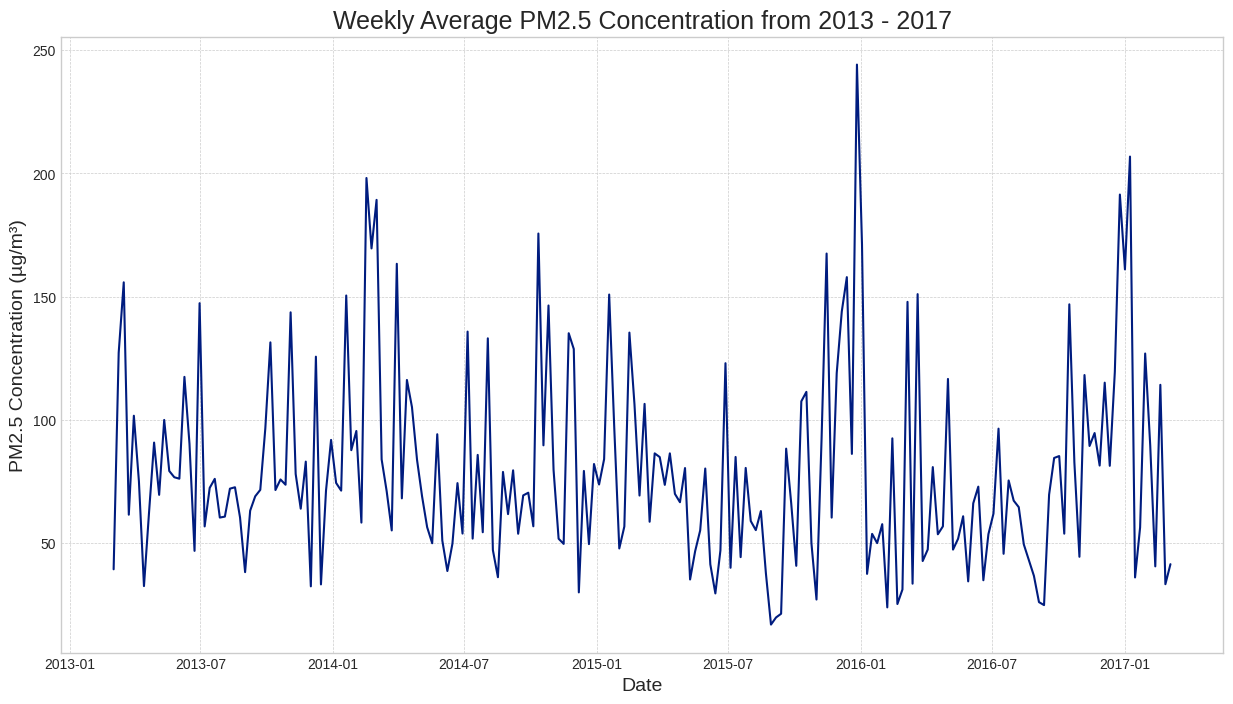

In [53]:
# --- Code for the Weekly Plot ---

# 1. Resample the PM2.5 data to a weekly ('W') frequency, calculating the mean for each week
df_weekly = df.resample('W').mean(numeric_only=True)

# 2. Create the plot using the new weekly data
plt.figure(figsize=(15, 8))
plt.plot(df_weekly.index, df_weekly["PM2.5"].values, label="PM2.5 Weekly Avg") # Plot the resampled data

# 3. Update the title and fix the y-axis label
plt.title('Weekly Average PM2.5 Concentration from 2013 - 2017', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=14) # Corrected typo in label
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

- Downsamples your time series to weekly frequency.

- Each row in the new DataFrame corresponds to one whole week.

- For each week, it takes all values in that week and computes the mean.

- The result has fewer rows (one per week), not one per hour.

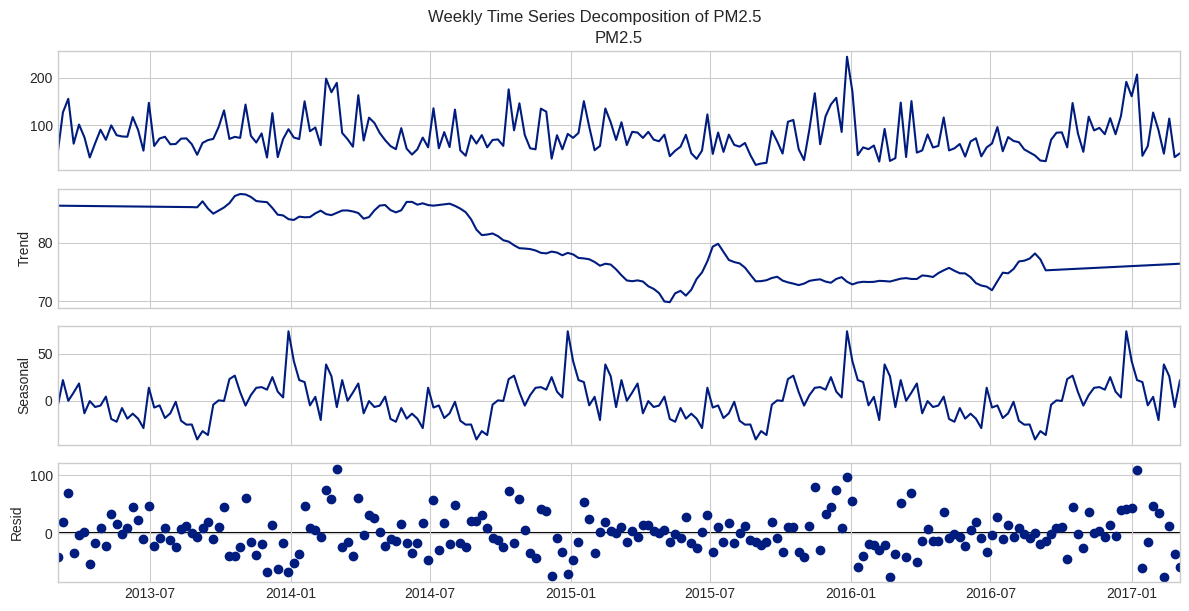

In [54]:
# time series decomposition
plt.style.use('seaborn-v0_8-dark-palette') # Changed to a valid seaborn style
plt.rcParams['figure.figsize'] = (12, 6)

# Set the period to 52 for weekly
decomposition = sm.tsa.seasonal_decompose(df_weekly["PM2.5"], model='additive', extrapolate_trend='freq', period=52)
fig = decomposition.plot()
plt.suptitle('Weekly Time Series Decomposition of PM2.5', y=1.01)
plt.show()

**Residual = Observed - Trend - Seasonal**

The random, unpredictable noise in the data. A good decomposition model successfully captures the main patterns (Trend and Seasonality), leaving a residual that has no clear pattern and hovers around zero. If the residual plot looks like random static with no discernible pattern, it means your model has done a good job of explaining the data's structure.

**Observed (top plot):** This is your actual PM2.5 values over time. Weekly PM2.5 bounces up and down.

**Trend:** Helps you see structural changes or policy impacts over years. Slowly declining from 2013 through ~2015, then flattening.

**Seasonality:** Confirms or quantifies recurring seasonal behaviour (e.g. winter smog). Repeating positive/negative pattern of ~±50 µg/m³ over the year — higher PM2.5 during certain months (maybe winter), lower in others (summer).

**Residual:** Good for identifying anomalies or one-off events you might want to investigate separately. A scatter of dots around zero — events not explained by the other two, e.g. sudden spikes in pollution.

In [55]:
df_weekly

PM2.5        PM10        SO2        NO2        CO         O3  \
datetime                                                                        
2013-03-03   39.364583   54.604745  30.075543  50.754032  1.038573  41.211366   
2013-03-10  127.241567  180.331349  55.173579  88.215680  2.042066  71.200893   
2013-03-17  155.800595  165.730159  54.156250  83.314484  1.769580  72.194444   
2013-03-24   61.516369   77.979167  16.282738  45.894979  0.914799  48.362750   
2013-03-31  101.675099  129.377976  32.131968  58.741951  1.249511  40.100761   
...                ...         ...        ...        ...       ...        ...   
2017-02-05   89.625744  101.417411  25.829365  49.353175  1.337475  48.738343   
2017-02-12   40.550843   58.882440  14.318948  37.086806  0.856225  55.461806   
2017-02-19  114.218502  134.889385  23.904266  69.202381  1.672842  38.721974   
2017-02-26   33.325149   45.853671   8.327877  40.124008  0.720957  47.399554   
2017-03-05   41.444444   63.377604  11.762153  54.585069  0.924219  43.944444   

                TEMP         PRES       DEWP      RAIN      WSPM  wd_degrees  \
datetime                                                                       
2013-03-03  2.230556  1022.445949 -16.248611  0.000000  1.842014  145.338542   
2013-03-10  7.921974  1008.608036  -7.972123  0.000000  1.878720  145.468750   
2013-03-17  6.276538  1013.946478  -3.122867  0.021280  1.480060  140.334821   
2013-03-24  4.453819  1009.503224  -6.526091  0.083978  2.288740  139.229911   
2013-03-31  6.928819  1012.459077  -5.007341  0.000000  1.917163  138.493304   
...              ...          ...        ...       ...       ...         ...   
2017-02-05  0.195096  1022.419610 -18.494494  0.000000  1.645238  161.729911   
2017-02-12  0.320208  1023.740451 -17.110516  0.000000  2.424157  175.312500   
2017-02-19  2.806101  1018.187401 -11.661756  0.000000  1.999157  128.816964   
2017-02-26  3.065476  1020.735764 -11.718304  0.022272  2.011012  191.328125   
2017-03-05  9.051389  1014.393750  -9.691493  0.000000  1.819965  175.234375   

                wd_E    wd_ENE    wd_ESE      wd_N     wd_NE    wd_NNE  \
datetime                                                                 
2013-03-03  0.042824  0.087963  0.023148  0.167824  0.119213  0.096065   
2013-03-10  0.061012  0.048611  0.063988  0.119544  0.098710  0.080853   
2013-03-17  0.064484  0.062996  0.092758  0.068948  0.098214  0.082341   
2013-03-24  0.056052  0.083333  0.076389  0.084325  0.102679  0.098710   
2013-03-31  0.076389  0.091766  0.115575  0.051587  0.101687  0.073909   
...              ...       ...       ...       ...       ...       ...   
2017-02-05  0.029266  0.079365  0.029266  0.070933  0.136905  0.093254   
2017-02-12  0.039187  0.059028  0.032242  0.100198  0.150794  0.061012   
2017-02-19  0.051091  0.110615  0.051587  0.095734  0.161706  0.120536   
2017-02-26  0.025794  0.040675  0.044147  0.075397  0.069940  0.073909   
2017-03-05  0.026042  0.059028  0.027778  0.086806  0.086806  0.128472   

              wd_NNW     wd_NW      wd_S     wd_SE    wd_SSE    wd_SSW  \
datetime                                                                 
2013-03-03  0.093750  0.086806  0.018519  0.019676  0.017361  0.047454   
2013-03-10  0.059524  0.043155  0.048611  0.053571  0.036706  0.090774   
2013-03-17  0.028770  0.028770  0.086806  0.070933  0.056548  0.094246   
2013-03-24  0.064484  0.032738  0.057540  0.053571  0.053571  0.074405   
2013-03-31  0.030754  0.032242  0.059524  0.072917  0.054563  0.074901   
...              ...       ...       ...       ...       ...       ...   
2017-02-05  0.081845  0.106151  0.045139  0.029266  0.029266  0.059028   
2017-02-12  0.140377  0.168651  0.022817  0.021825  0.032738  0.027778   
2017-02-19  0.097222  0.057044  0.035714  0.051091  0.043651  0.029266   
2017-02-26  0.114583  0.109127  0.048611  0.030258  0.027282  0.041667   
2017-03-05  0.116319  0.151042  0.032986  0.010417  0.026042  0.059028 

## Monthly For Decomposition

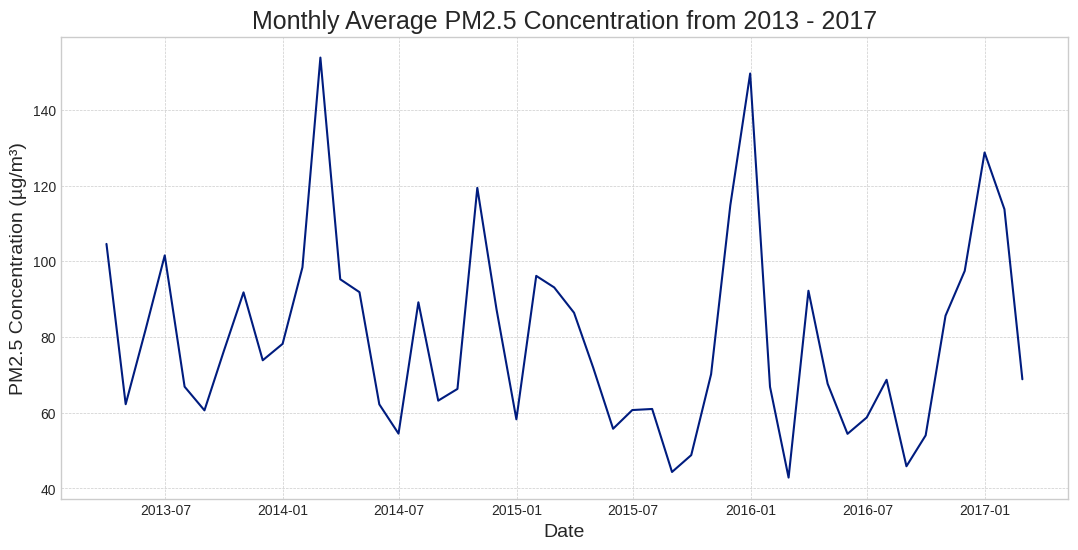

In [56]:
# 1. Resample the PM2.5 data to a monthly ('W') frequency, calculating the mean for each month
df_monthly = df.resample('ME').mean(numeric_only=True) # Aggregates your data by month-end across time.

# 2. Create the plot using the new weekly data
plt.figure(figsize=(13, 6))
plt.plot(df_monthly.index, df_monthly["PM2.5"].values, label="PM2.5 Monthly Avg") # Plot the resampled data

# 3. Update the title and fix the y-axis label
plt.title('Monthly Average PM2.5 Concentration from 2013 - 2017', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=14) # Corrected typo in label
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [57]:
# 1. Resample to monthly mean
df_monthly = df.resample('ME').mean(numeric_only=True) # Aggregates your data by month-end across time.

# 2. Decompose the monthly PM2.5 series
#    period = 12 means "assume a yearly seasonal cycle of 12 months"
decomposition_monthly = sm.tsa.seasonal_decompose(
    df_monthly["PM2.5"],
    model='additive',           # or 'multiplicative'
    period=12,                  # 12 months per year
    extrapolate_trend='freq'    # optional to fill edges
)

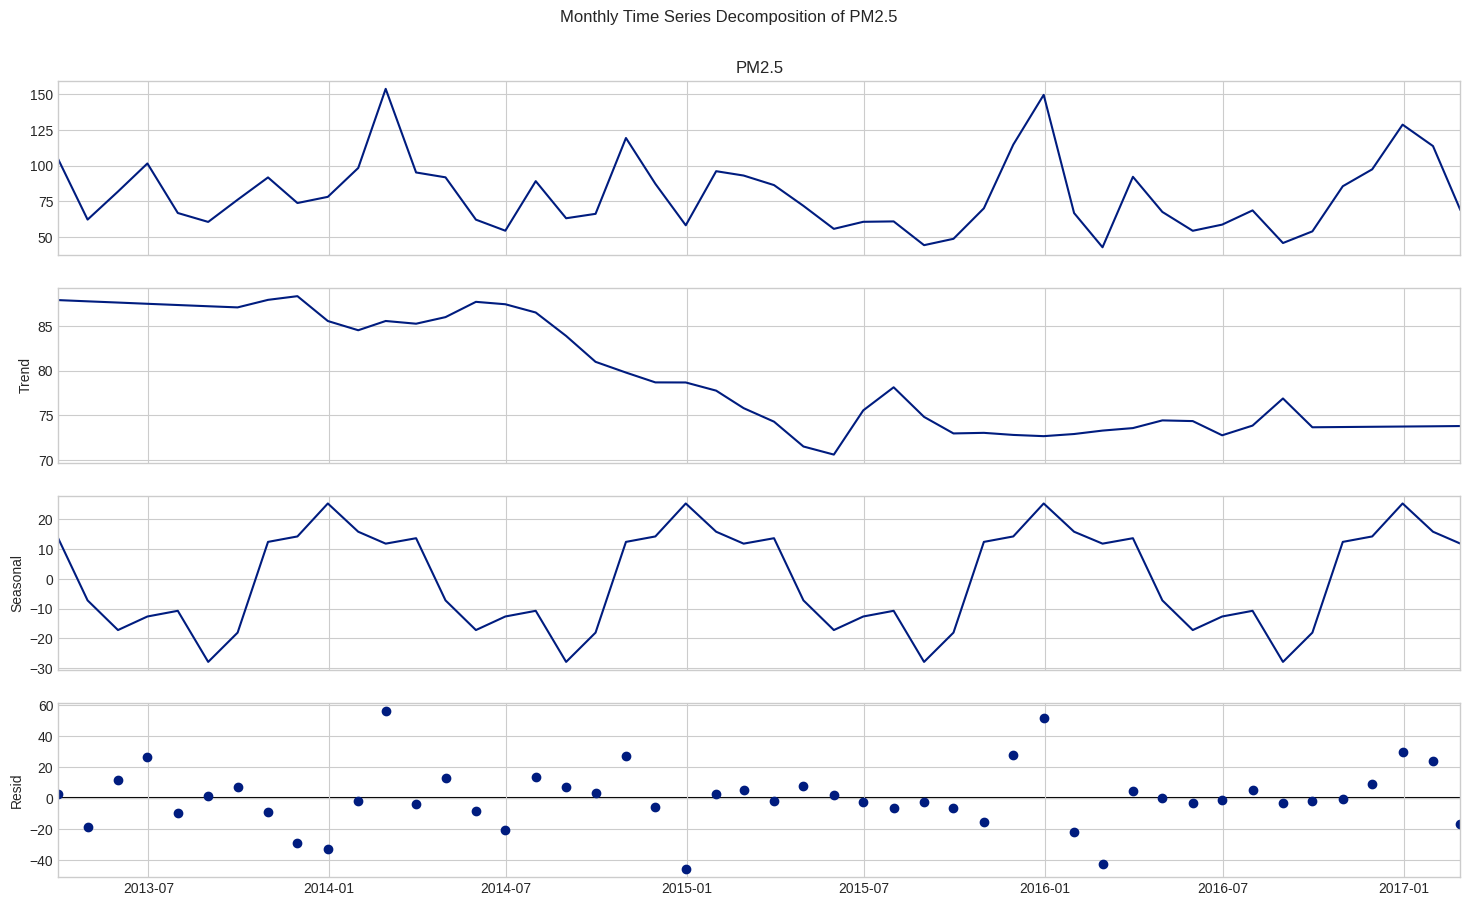

In [58]:
# 3. Plot
fig = decomposition_monthly.plot()
fig.set_size_inches(15, 9)  # adjust size
plt.suptitle('Monthly Time Series Decomposition of PM2.5', y=1.02)
plt.show()

## Seasonal/Cyclical Features

In [59]:
day_of_year = df.index.dayofyear
# Create cyclical seasonal features
# We divide by 365.25 to account for leap years
df['day_of_year_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

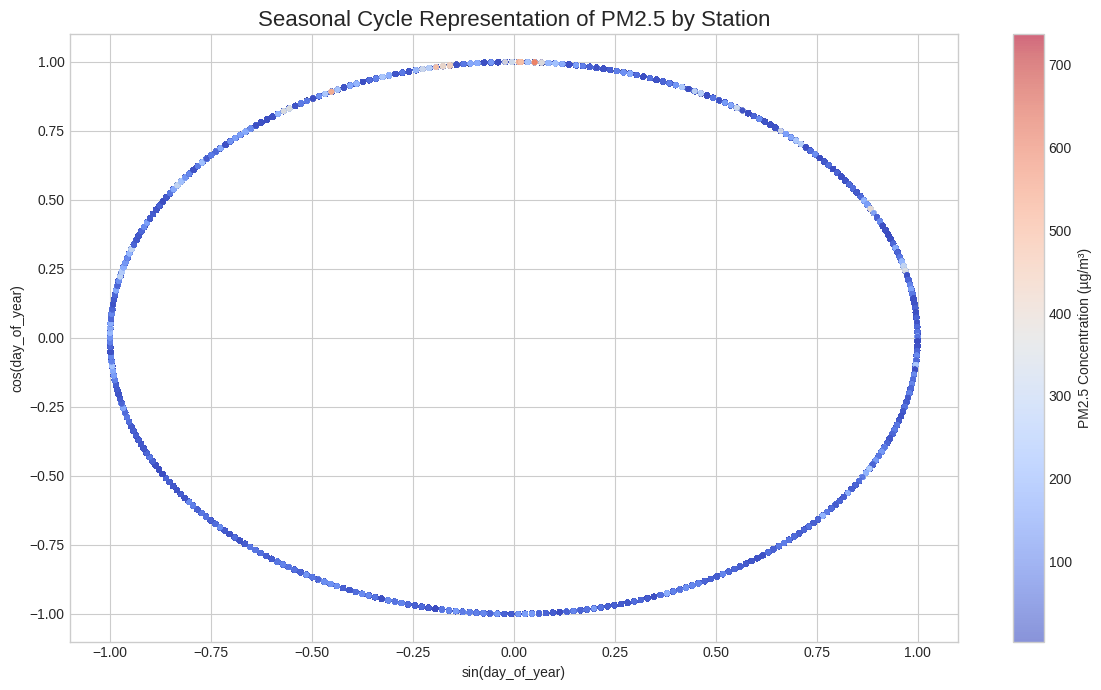

In [60]:
plt.figure(figsize=(12, 7))

# Plot each station’s seasonal pattern
for station in df['station'].unique():
    station_data = df[df['station'] == station]
    plt.scatter(
        station_data['day_of_year_sin'],
        station_data['day_of_year_cos'],
        c=station_data['PM2.5'],
        cmap='coolwarm',
        alpha=0.6,
        label=station,
        s=10
    )

# Titles and labels
plt.title("Seasonal Cycle Representation of PM2.5 by Station", fontsize=16)
plt.xlabel("sin(day_of_year)")
plt.ylabel("cos(day_of_year)")

# Legend outside the plot
#plt.legend(title="Stations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.colorbar(label="PM2.5 Concentration (µg/m³)")
plt.tight_layout()
plt.show()

This makes a circular seasonal plot (values cluster by seasons — e.g., winter vs summer will be on opposite sides of the circle).
Each station gets its own colored cluster, and the colormap (coolwarm) encodes PM2.5 values.

**Explaining the Circular Graph**
This plot uses a clever trick with sine and cosine to wrap the 365 days of the year into a circle.

- **What it is:** Think of it as a clock face for the entire year. **Each dot on the circle represents a single day.** The **top** of the circle is roughly **mid-winter** (around December/January), the **bottom** is **mid-summer** (June/July), the **right** side is **spring**, and the **left** is **autumn**.

- **What it shows:** The color of **each dot represents** the PM2.5 concentration on that **day**. The color bar on the right shows that blue is low concentration and red is high concentration.

- **The Key Insight:** You can clearly see a seasonal pattern. The top of the circle has more red and orange dots, meaning PM2.5 is consistently higher in the winter. The bottom of the circle is almost entirely blue, meaning PM2.5 is consistently lower in the summer.

# Interaction Feature Analysis

We want to see all interactions between PM2.5 and meteoorological columns.

In [61]:
meteo_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

wd_cols = [c for c in df.columns if c.startswith('wd_')]

station_cols = [c for c in df.columns if c.startswith('station_')]

feature_cols = ['PM2.5'] + meteo_cols + wd_cols + station_cols

df_interact = df[feature_cols]

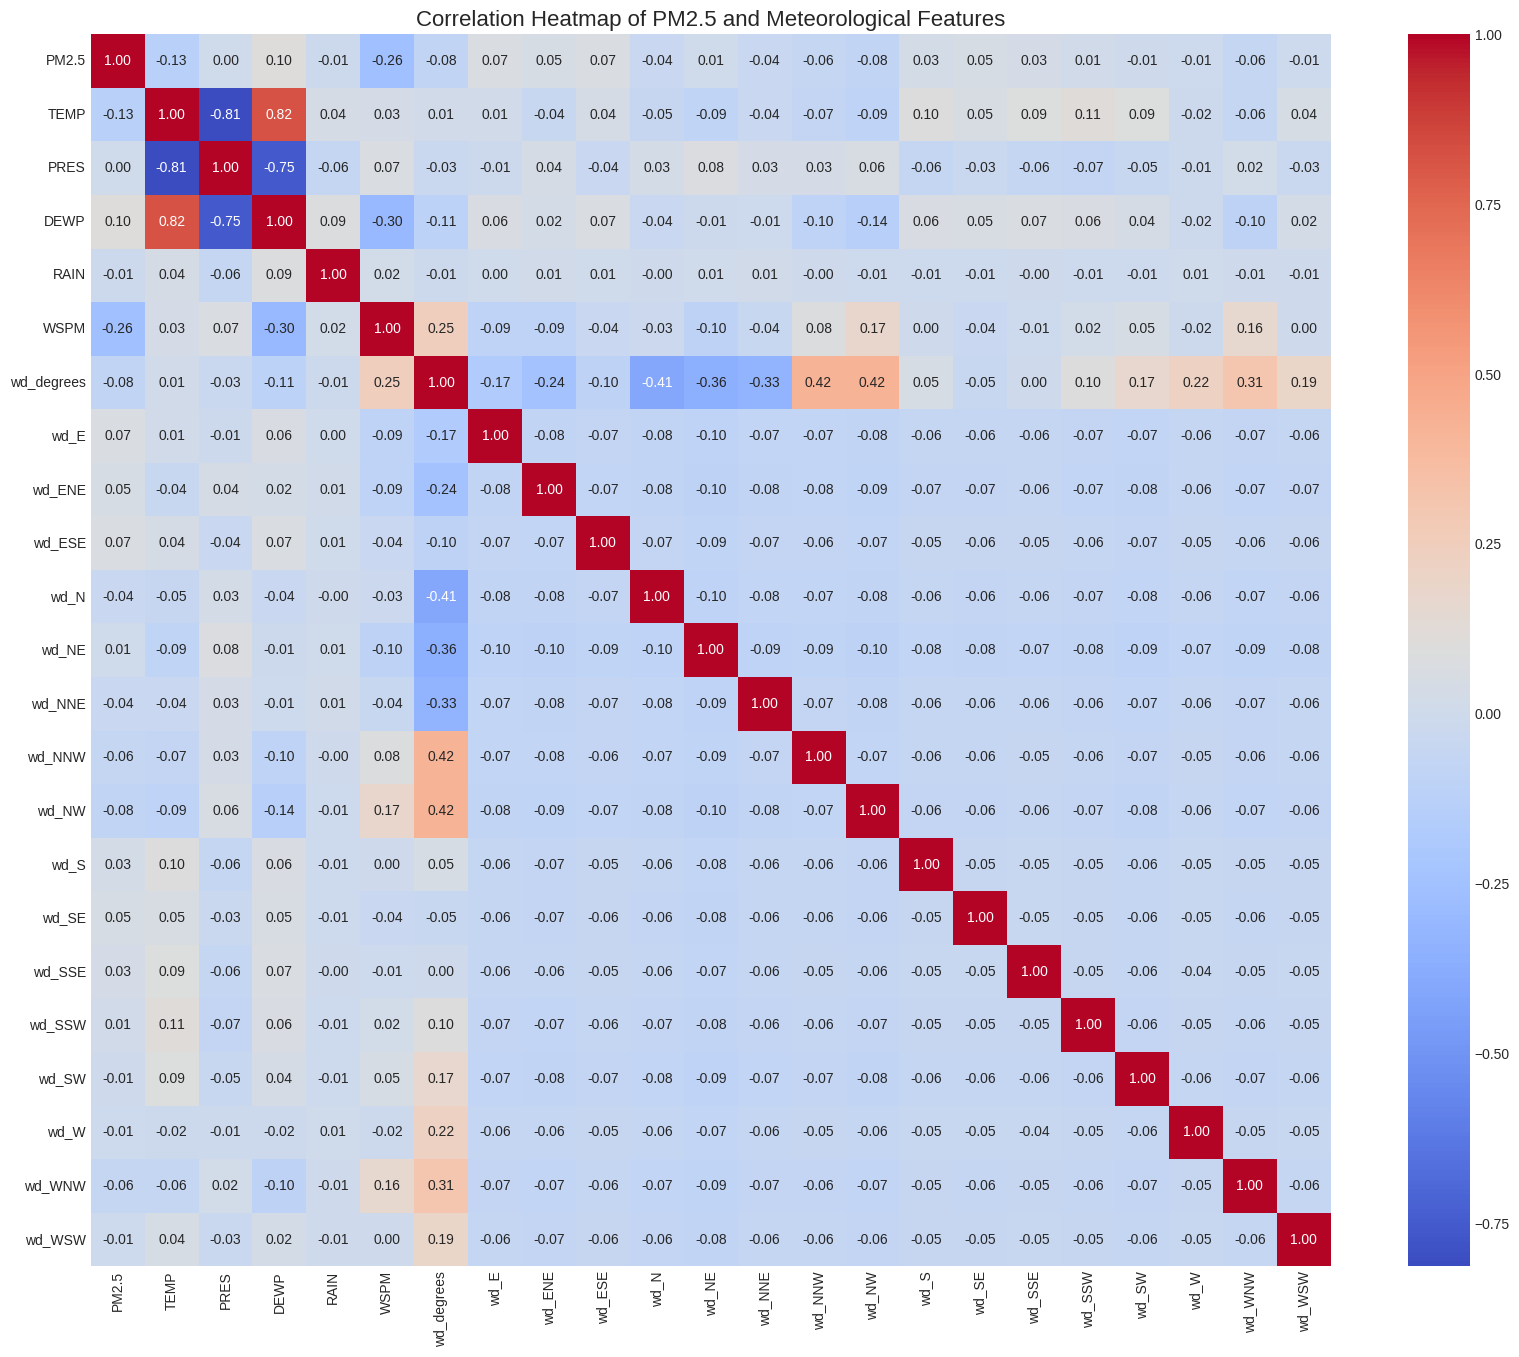

In [62]:
# Calculate the correlation matrix
corr_matrix = df_interact.corr()
# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm', # Use a diverging colormap
    annot=True,      # Set to True if you want numbers, but can be messy
    fmt='.2f'
)

plt.title('Correlation Heatmap of PM2.5 and Meteorological Features', fontsize=16)
plt.show()

**Wind Speed (WSPM):** This is the most significant meteorological factor for predicting PM2.5. It has a moderate negative correlation of -0.26. This confirms the expected relationship: as wind speed increases, pollution disperses and PM2.5 levels decrease.

While other correlations appear weak, it doesn't mean they're useless. The relationships may be non-linear, which more complex models like XGBoost or LSTMs can capture effectively.